Explorative Data Analysis for Kaggle House Price prediction
===============

This notebook contains charts I made during the explorative analysis of the data. It serves as a form of documentation and substantiates the transformations made in the `Model` notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from utils import data_profile, hist_compare

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
COL_Y = 'SalePrice'

# Load data

In [66]:
df_train = pd.read_csv('data/train.csv', index_col='Id')
df_test = pd.read_csv('data/test.csv', index_col='Id')
df = pd.concat((df_train, df_test))

print("n:", len(df), "n_cols: ", len(df.columns))

n: 2919 n_cols:  80


# High level overview

In [4]:
df.dtypes.value_counts()

object     43
int64      25
float64    12
dtype: int64

In [5]:
def cols_of_dtype(df, dtype):
    return sorted([c for c in df.columns if df[c].dtype == dtype])

In [6]:
for dtype in df.dtypes.value_counts().index:
    print("-> Dtype: ", dtype)
    print(repr(cols_of_dtype(df, dtype)))
    print("-----")

-> Dtype:  object
['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']
-----
-> Dtype:  int64
['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LowQualFinSF', 'MSSubClass', 'MiscVal', 'MoSold', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'PoolArea', 'ScreenPorch', 'TotRmsAbvGrd', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'YrSold']
-----
-> Dtype:  float64
['BsmtFinSF1'

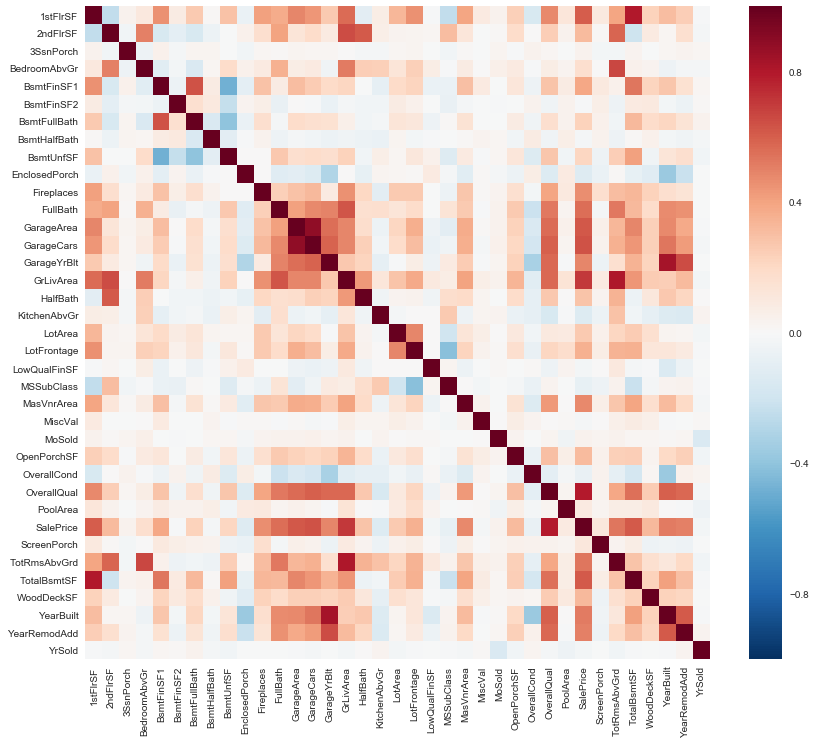

In [7]:
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr())

Some immediate observations:
- Vars strongly correlated with SalePrice are: `1stFlrSF`, `FullBath`, `GarageArea`, `GarageCars`, `GrLivArea`, `OverallQual`, `TotalBsmtSF`.
- There also is some collinearity between e.g. `GarageArea` and `GarageCars`. Which makes total sense, the bigger it is the more cars fit inside. I'm not going to worry a lot about this though, because I'm not concerned with stability of coefficients, only with good predictions. But it might make sense to keep only one of the two.
- Some vars have almost no correlation, e.g. `MoSold` and `YrSold`. Looks like we can safely drop these, but we might be able to extract some value out of them before dropping them.
- There isn't any substantial negative correlation between `SalePrice` and any other variable, so we can focus on positive correlations.

Zoom in a bit on highly (positively) correlated vars:

In [8]:
high_corr = df.corr()[COL_Y].sort_values(ascending=False).head(15)

In [9]:
print(high_corr)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64


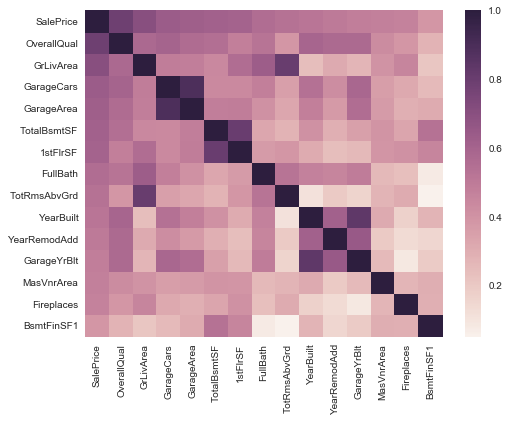

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[high_corr.index.tolist()].corr());

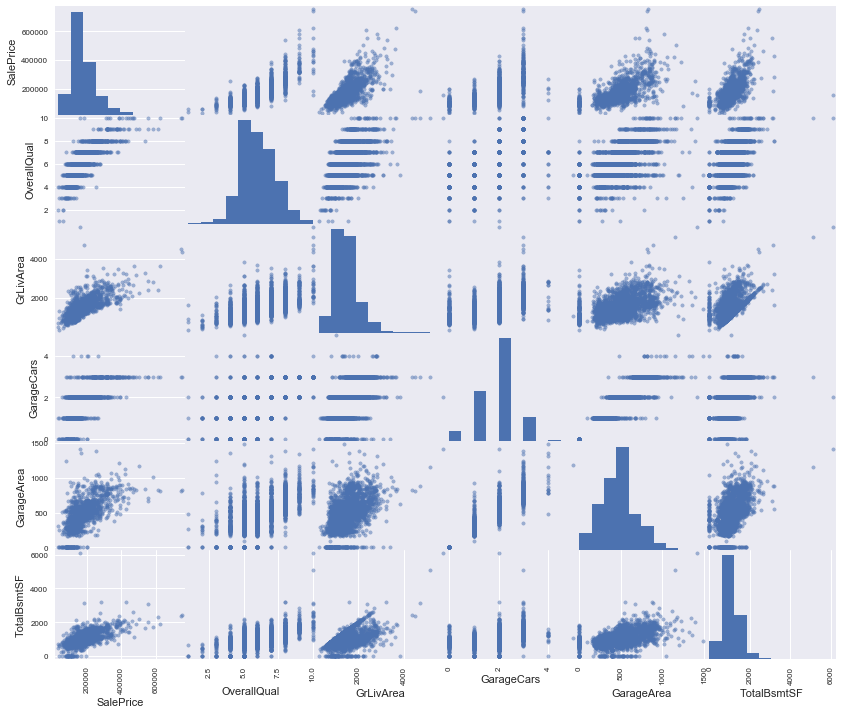

In [11]:
pd.scatter_matrix(df[high_corr[:6].index.tolist()], figsize=(14,12));

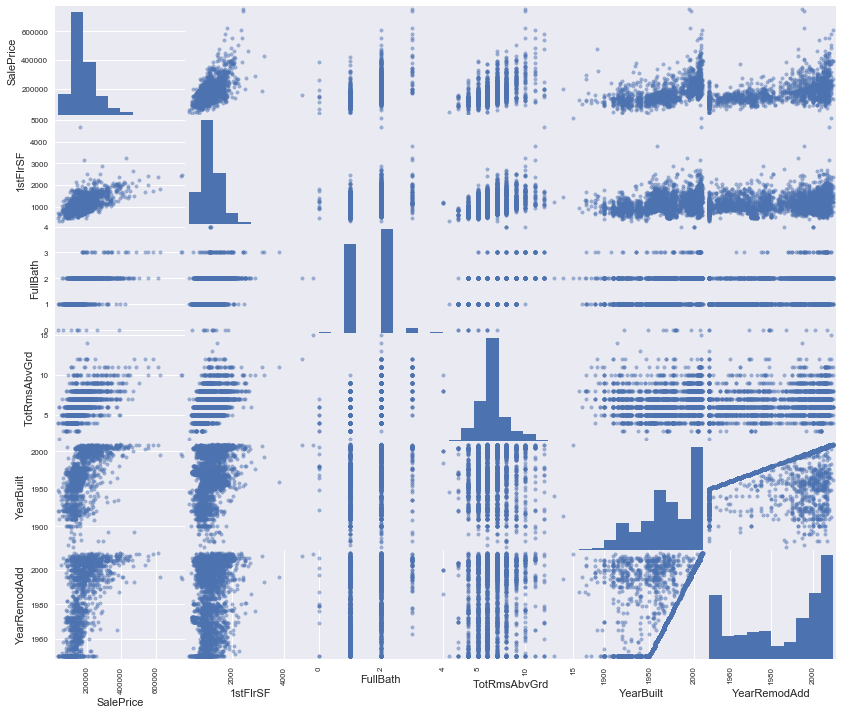

In [12]:
pd.scatter_matrix(df[[COL_Y] + high_corr[6:11].index.tolist()], figsize=(14,12));

Observations:
- I see a couple of approximately linear relations, e.g. `SalePrice` and `GrLivArea` (as we would expect, given the filter on highly correlated vars)
- Distributions don't look normal. Right skews could warrant a log/sqrt transformation. Will look into this later.
- Should be wary for outliers. E.g. `GrLivArea` shows 2 big houses with pretty low Sale Price. Will looko into this later as well.
- Interesting structure between `GrLivArea` and `TotalBsmtSF`. I guess it's pretty rare to have a basement that's bigger than the living room. I expect the same with `1srFlrSF` and `GrLivArea` (although it's not in this plot, might check this out in more detail below).
- Recently built houses seem a bit more expensive. There's also more of them. Recently remodeled houses may also be more expensive but it's difficult to see. These `Year` distributions seem difficult to deal with. See `YearRemodAdd`; there's a big peak at around 1950. Looks like some sort of default value. Will consider doing something about this.

Ok, these were the important numeric fields. I have some ideas on what to look out for later. Will check categorical fields one by one below.

# Detailed inspections
The order here roughly corresponds with the transformations in the `Model` notebook.

### SalePrice
The scatterplot matrix showed that SalePrice is right-skewed. I'm not 100% sure on the theory here because I've only ever seen it being done on the dependent variables, but I have a feeling that it'll help. Crossvalidation confirmed it later on.

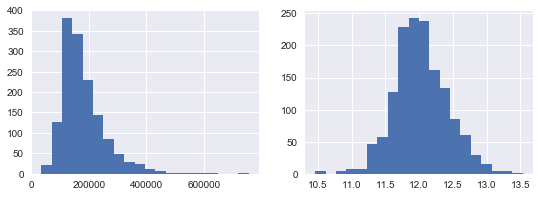

In [14]:
_, (l, r) = plt.subplots(ncols=2, figsize=(9, 3))
l.hist(df['SalePrice'].dropna().values, bins=20);
r.hist(np.log(df['SalePrice'].dropna().values), bins=20);

### Alley

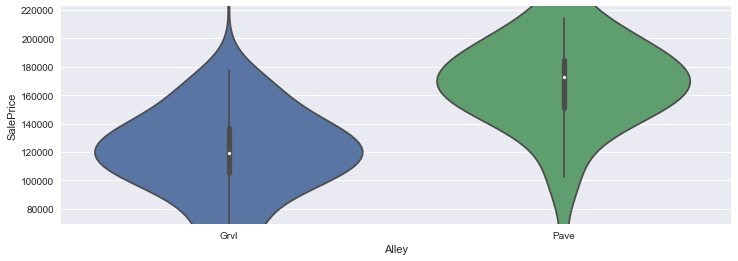

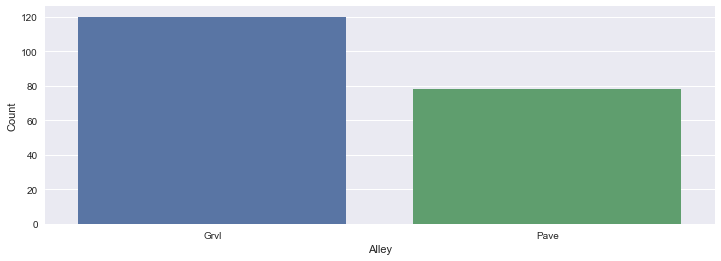

2721  missing entries


In [15]:
data_profile(df, 'Alley')

A lot of missing values - probably best to delete it.

### MSSubClass

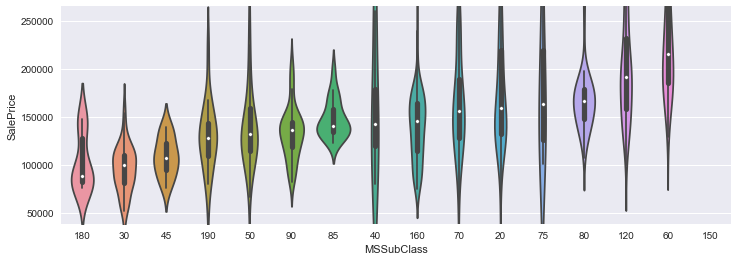

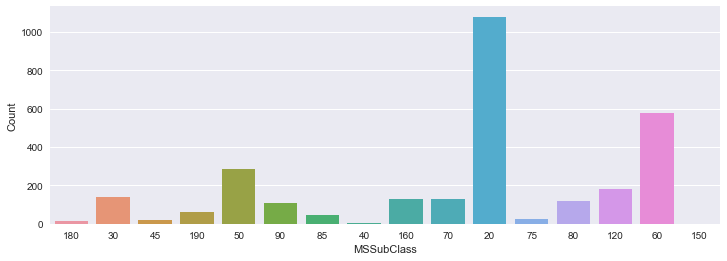

0  missing entries


In [16]:
data_profile(df, 'MSSubClass', dtype='cat')

Let's also combine some MSSubClass'es that are close together, have a simular distribution, but only have few examples: 
- 40 and 160
- 70, 20, 75
- 190, 50, 90
- 30, 34, 180

Oh, there's only one with 150 and it's part of the test set ... better delete it and impute it with a different value from a similar home.

### LotShape

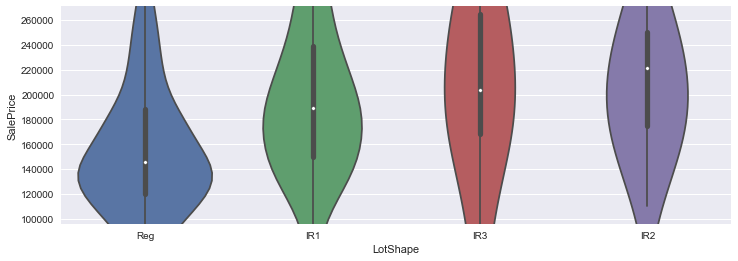

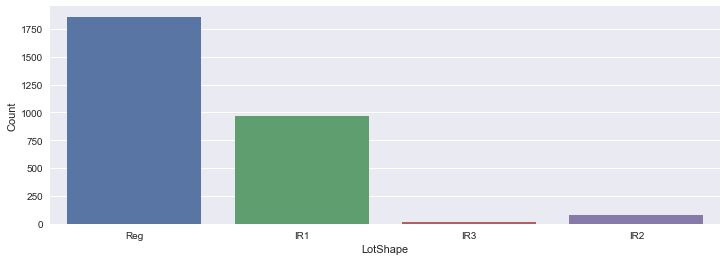

0  missing entries


In [17]:
data_profile(df, 'LotShape')

There's 3 values for irregular lot shape. Let's turn it into a binary variable. Doesn't look like we'll lose a whole lot of information and it makes it easier to train.

#### LandContour

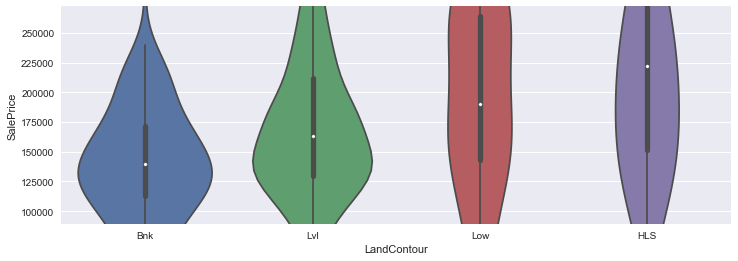

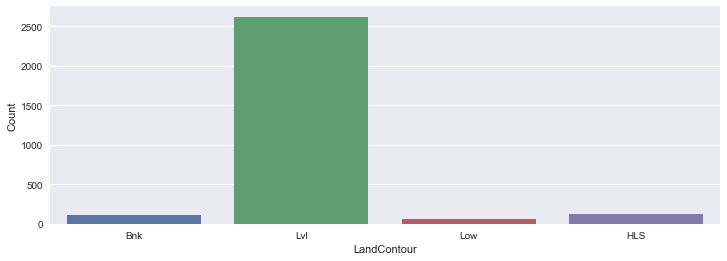

0  missing entries


In [18]:
data_profile(df, 'LandContour')

"Lvl" occurs very often, the other ones do not. Will try to combine Bnk and Lvl and one-hot encode this manually.

#### Utilities

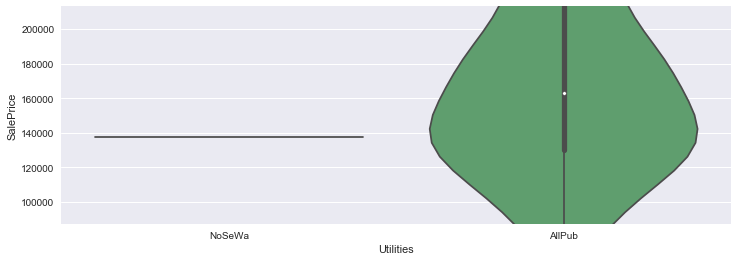

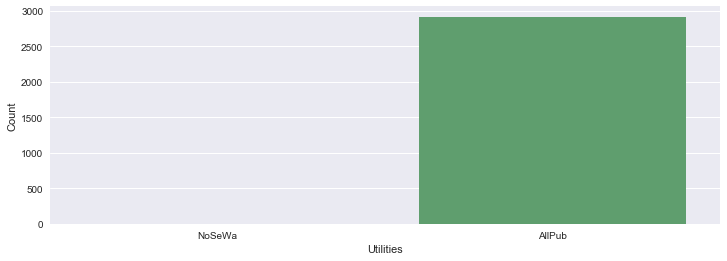

2  missing entries


In [19]:
data_profile(df, 'Utilities')

Only 1 house with NoSeWa? Let's drop it. 

#### LotConfig

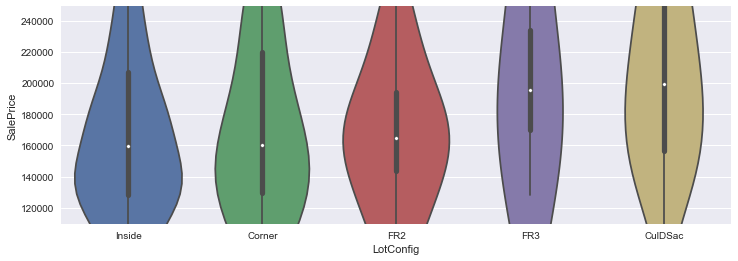

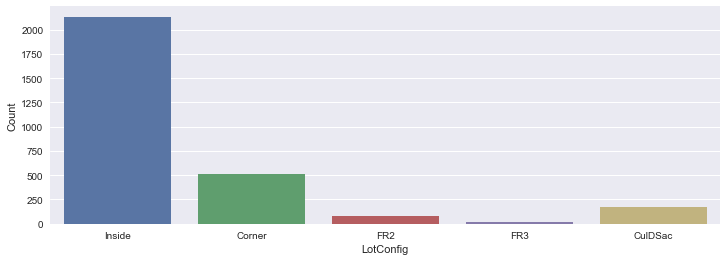

0  missing entries


In [20]:
data_profile(df, 'LotConfig')

Combine FR3 + CuldSac. And Inside + Corner.

### LandSlope

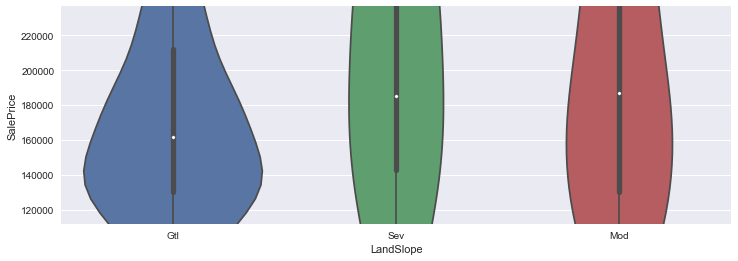

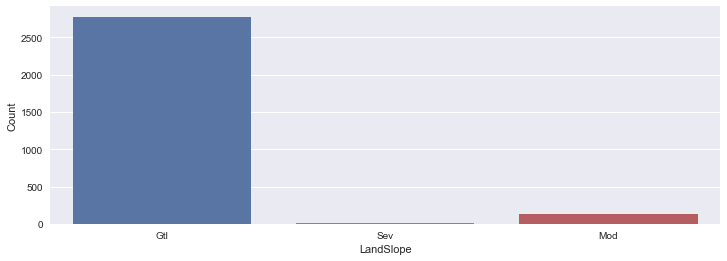

0  missing entries


In [21]:
data_profile(df, 'LandSlope')

Will make a binary value with Gtl or not Gtl.

### Neighbourhood

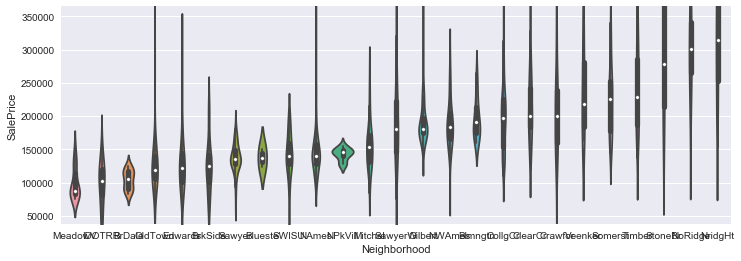

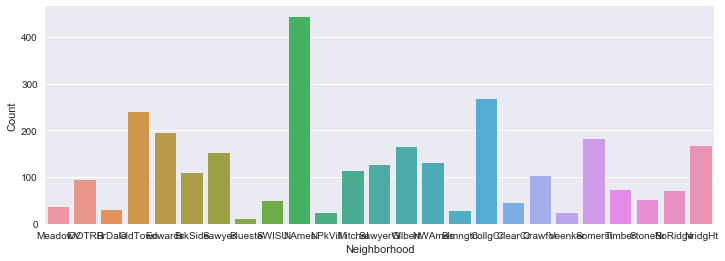

0  missing entries


In [22]:
data_profile(df, 'Neighborhood')

Ok, this looks like a very strong relationship. I can simply one-hot encode all of them.
Or, I could try to make the modelling a little easier by grouping these into cheap, regular and expensive neighbourhoods. Will give that a shot. The cutoffs I'm choosing are a bit arbitrary, I'm looking for big jumps in the graph for the median sale price (the white circle). Will validate if this works with CV.

In [23]:
nb_sp = df.groupby('Neighborhood')[['SalePrice']].median()
nb_sp[nb_sp['SalePrice'] > 200000]

,SalePrice
Neighborhood,
ClearCr,200250.0
Crawfor,200624.0
NoRidge,301500.0
NridgHt,315000.0
Somerst,225500.0
StoneBr,278000.0
Timber,228475.0
Veenker,218000.0


Cheap neighbourhoors:

In [24]:
nb_sp[nb_sp['SalePrice'] < 160000].index.get_level_values(0).values

array(['Blueste', 'BrDale', 'BrkSide', 'Edwards', 'IDOTRR', 'MeadowV',
       'Mitchel', 'NAmes', 'NPkVill', 'OldTown', 'SWISU', 'Sawyer'], dtype=object)

Expensive neighbourhoods:

In [25]:
nb_sp[nb_sp['SalePrice'] > 200000].index.get_level_values(0).values

array(['ClearCr', 'Crawfor', 'NoRidge', 'NridgHt', 'Somerst', 'StoneBr',
       'Timber', 'Veenker'], dtype=object)

### YearRemodelAdd,  YearBuilt, YrSold, MoSold

- YearRemodAdd: Remodel date (same as construction date if no remodeling or additions). According to description. But we've already seen a strange peak at 1950.

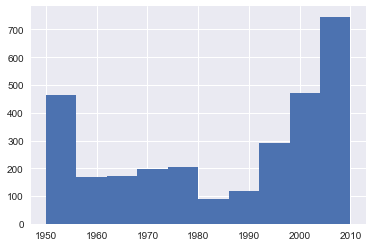

In [26]:
df['YearRemodAdd'].hist()

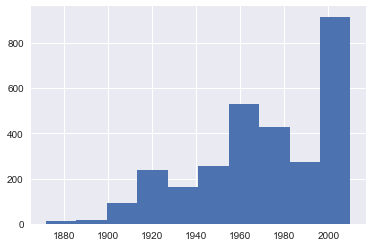

In [27]:
df['YearBuilt'].hist()

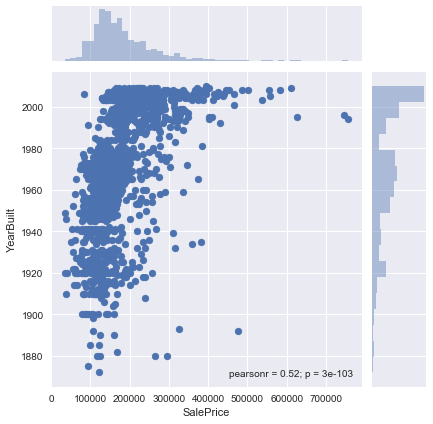

In [28]:
sns.jointplot('SalePrice', 'YearBuilt', df)

Let's try to add some features. Above, I noticed that it makes no sense to keep YoSold and MoSold around. But it might be possible to extract some value from them first.

New: 117 | Old: 2802


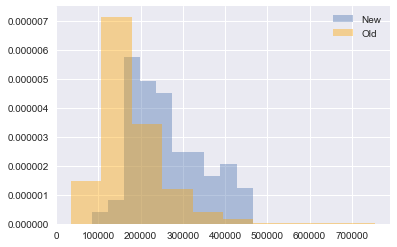

In [29]:
cond = (df['YearBuilt'] == df['YrSold']) | \
       (df['YearBuilt']-1 == df['YrSold'])
hist_compare(cond, "New","Old", df)

Ok, new houses seem more expensive. Will add 'isNew' feature.

NotRemodeledAfterConstruction: 1899 | RemodeledAfterConstruction: 1020


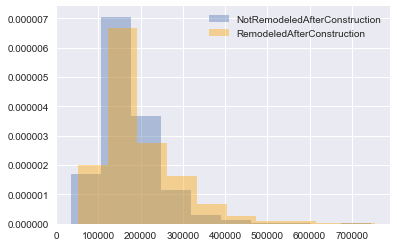

In [30]:
cond = (df['YearBuilt'] == df['YearRemodAdd']) | \
       ((df['YearRemodAdd'] == 1950) & (df['YearBuilt'] != 1950))
hist_compare(cond, 
             "NotRemodeledAfterConstruction",
             "RemodeledAfterConstruction", df)

Not very discriminative. Let's try something else.

RemodeledInYearOfSaleOrLater: 241 | NotRemodeledAfterConstruction: 2678


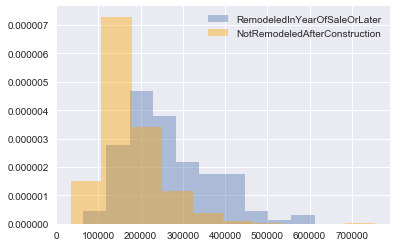

In [32]:
hist_compare((df['YearRemodAdd'] >= df['YrSold']), 
             "RemodeledInYearOfSaleOrLater", 
             "NotRemodeledAfterConstruction",
             df)

Ok, good! Adding this.

In [33]:
df[[COL_Y, 'YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold']].corr()

,SalePrice,YearBuilt,YearRemodAdd,YrSold,MoSold
SalePrice,1.000000,0.522897,0.507101,-0.028923,0.046432
YearBuilt,0.522897,1.000000,0.612235,-0.012344,0.013938
YearRemodAdd,0.507101,0.612235,1.000000,0.033203,0.017693
YrSold,-0.028923,-0.012344,0.033203,1.000000,-0.153895
MoSold,0.046432,0.013938,0.017693,-0.153895,1.000000


Even though the distributions for YearBuilt and YearRemodAdd look very much non-normal, it's still worthwhile to keep them. Might want to look into bining them into decades and one-hot-encoding that later. But I will fix the 1950 issue.


In [31]:
df['YearRemodAdd'].min()

1950

In [34]:
len(df.loc[(df['YearRemodAdd'] == 1950) & (df['YearBuilt'] == 1950), :])

22

In [35]:
len(df.loc[(df['YearRemodAdd'] == 1950) & (df['YearBuilt'] > 1950), :])

0

In [36]:
len(df.loc[(df['YearRemodAdd'] == 1950) & (df['YearBuilt'] < 1950), :])

339

It could be that all these houses were infact remodeled in 1950, but it looks too fishy to me...

YrSold and MoSold will be dropped. Can take a quick look at MoSold, just in case:

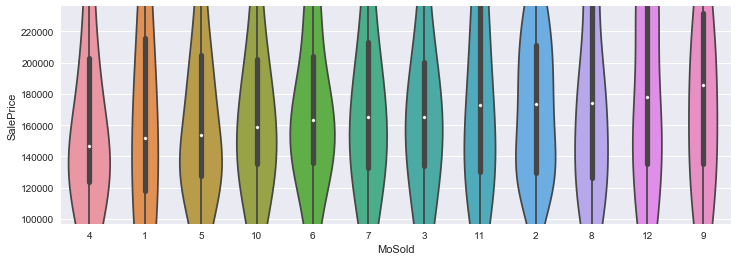

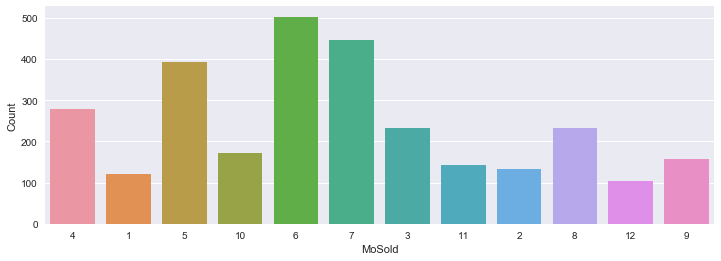

0  missing entries


In [37]:
data_profile(df, 'MoSold', dtype='cat')

What's up with this?
Good months: 2, 8, 9, 11 12
Bad months: 1, 4, 5, 10

I could maybe try one-hot-encoding this so that each month can be used individually but it doesn't really make sense to me intuitively. As it is right now, as an ordinal column, it's just noise. Definitively dropping it.

### Roof

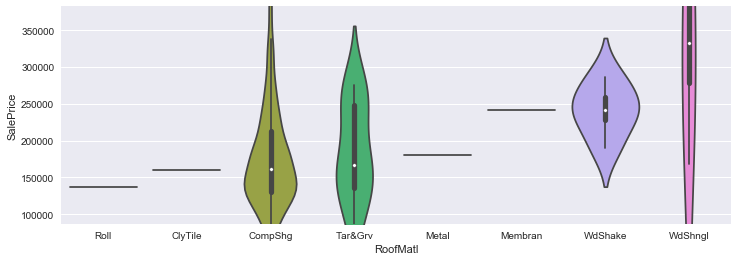

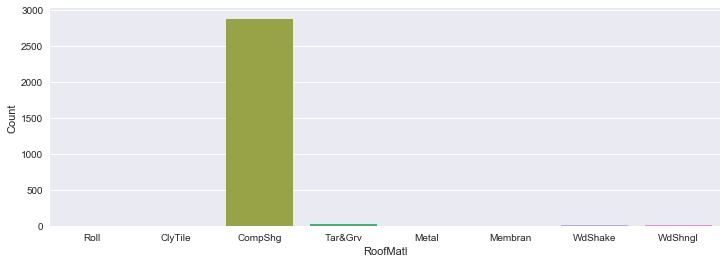

0  missing entries


In [38]:
data_profile(df, 'RoofMatl')

I can't see this adding much predictive value, only a lot of noise.

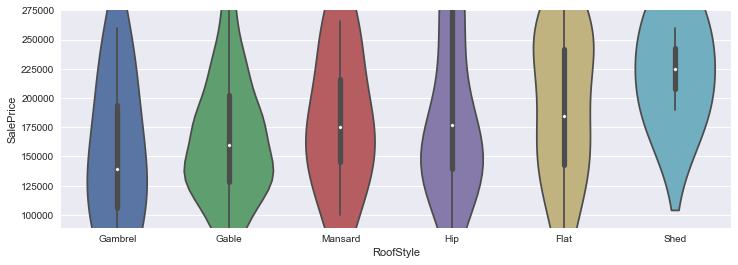

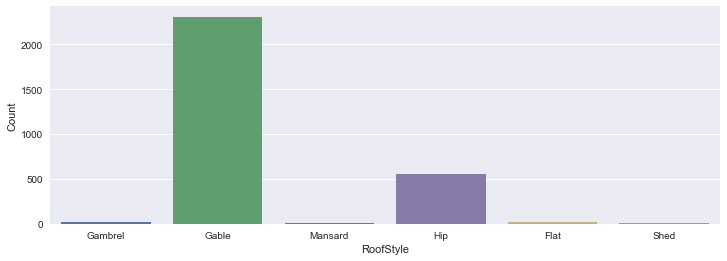

0  missing entries


In [39]:
data_profile(df, 'RoofStyle')

This might help but there's many categories with few values. I'll combine Gambrel and Gable. And Mansard, Hip, Flat, Shed.

### MiscFeature

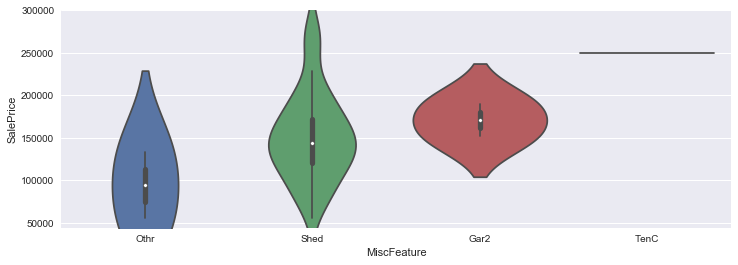

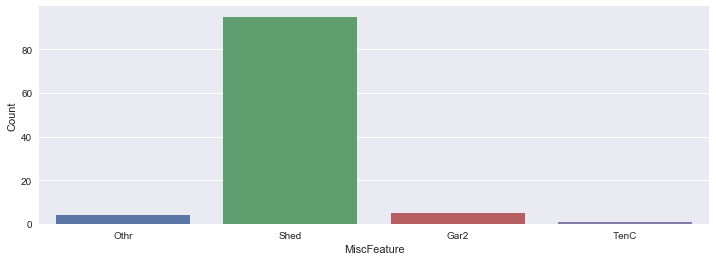

2814  missing entries


In [40]:
data_profile(df, 'MiscFeature')

Ok, only shed has a meaningful amount of values. Gar2 could be used to distinguish expensive houses but I thinking this is already incorporated in the garage size / nr. of vehicles. Let's compare shed v.s. nonshed.

Shed: 95 | No Shed: 2824


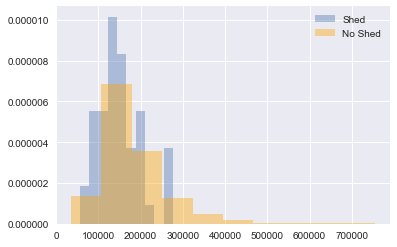

In [41]:
hist_compare(df['MiscFeature'] == 'Shed', 'Shed', 'No Shed', df)

No, too much overlap. Dropping it.

(Note to self: look into consistent binning between the 2 histograms)

### Condition1, condition2

    Artery	Adjacent to arterial street
    Feedr	Adjacent to feeder street	
    Norm	Normal	
    RRNn	Within 200' of North-South Railroad
    RRAn	Adjacent to North-South Railroad
    PosN	Near positive off-site feature--park, greenbelt, etc.
    PosA	Adjacent to postive off-site feature
    RRNe	Within 200' of East-West Railroad
    RRAe	Adjacent to East-West Railroad
    
Ok, there's 2 columns that have the same entries. These should definitely be combined when one-hot-encoding. Makes no sense to have a separate Condition1_Feedr and a separate Condition2_Feedr. But let's focus on Condition1 for the analysis because it contains more values that aren't "Normal".

In [42]:
df['Condition1'].value_counts()

Norm      2511
Feedr      164
Artery      92
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition1, dtype: int64

In [43]:
df['Condition2'].value_counts()

Norm      2889
Feedr       13
Artery       5
PosA         4
PosN         4
RRNn         2
RRAe         1
RRAn         1
Name: Condition2, dtype: int64

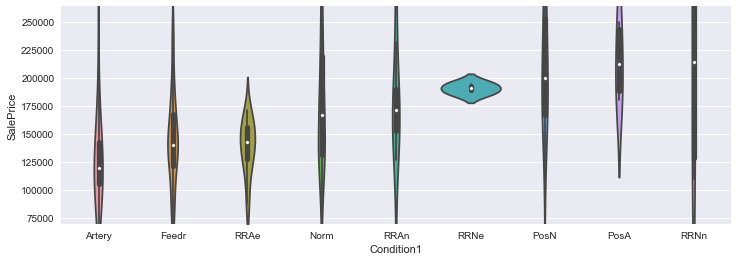

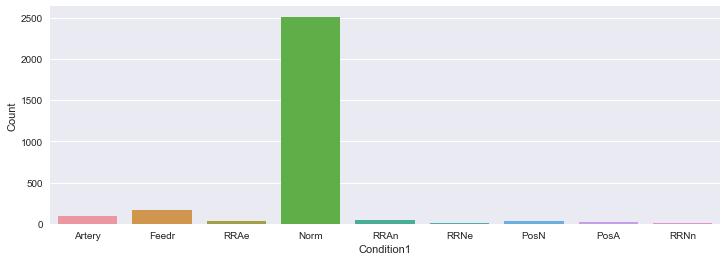

0  missing entries


In [44]:
data_profile(df, 'Condition1')

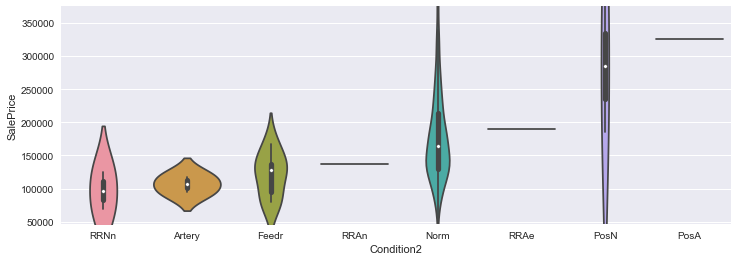

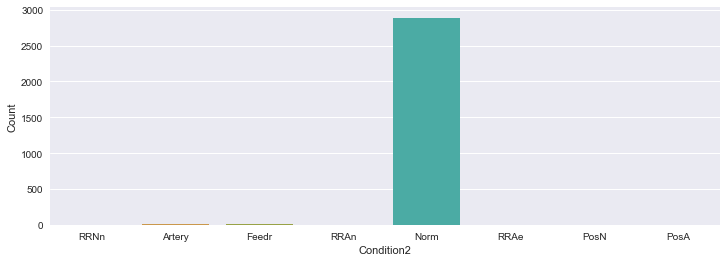

0  missing entries


In [45]:
data_profile(df, 'Condition2')

Notice how RRNn is on the right side for Condition1 and left for Condition2?

Ok, I'm willing to accept that being close to an Artery of Feedr results in a low price. Will one hot encode these manually and drop the others. The difference between artery and feedr is big enough to warrant their own variables.

## Exterior1st, Exterior2nd
Same story as for Condition.

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

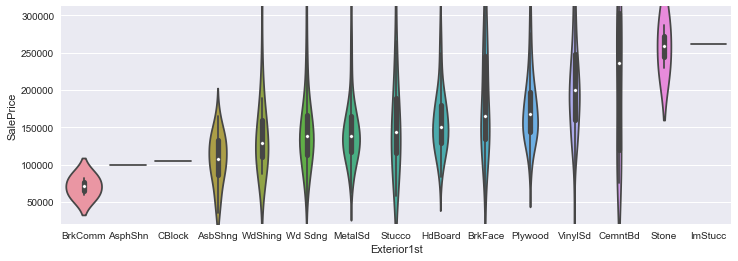

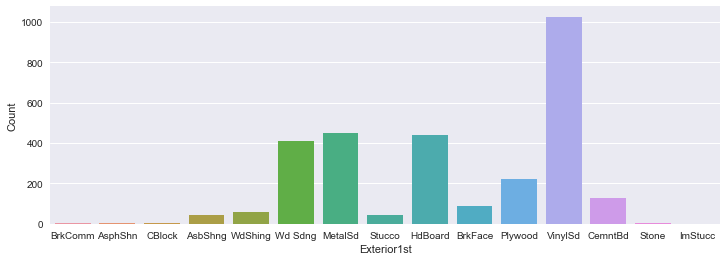

1  missing entries


In [46]:
data_profile(df, 'Exterior1st')

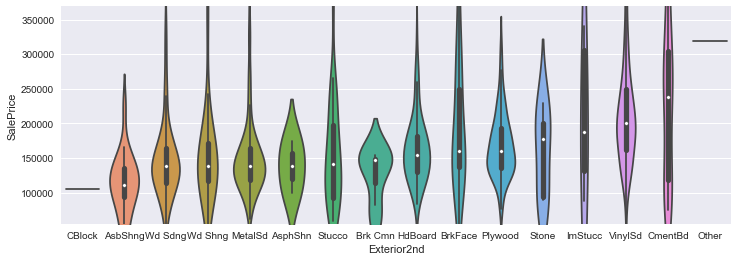

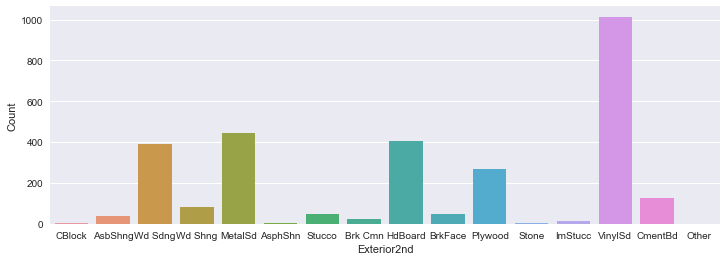

1  missing entries


In [47]:
data_profile(df, 'Exterior2nd')

I'm only keeping the materials with a sizeable amount of examples:

Cheap materials
- AsbShng
- WdShing
- Wd Sdng
- MetalSd

Medium materials:
- Stucco
- HdBoard
- BrkFace
- Plywood

Expensive materials:
- VinylSd
- CemntBd
- CmentBd (looks like they made a typo!)
- ImStucc

Will hot encode these as three variables.

### SaleCondition, SaleType, HouseStyle, MasVnrType, Electrical, BldgType, Foundation, Heating

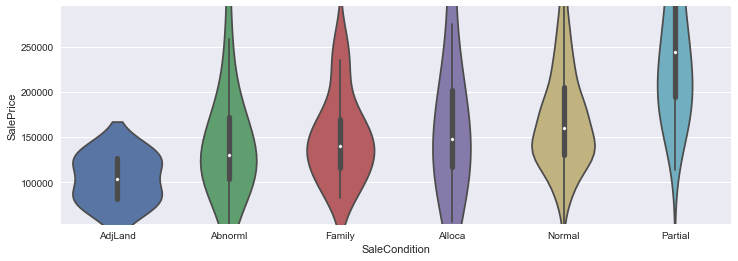

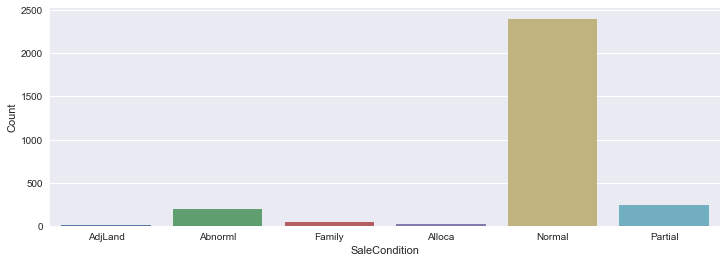

0  missing entries


In [48]:
data_profile(df, 'SaleCondition')

There's a lot in Normal and not a whole lot in the others. Some relation with SalePrice but I'm not really convinced. Will try to drop it.

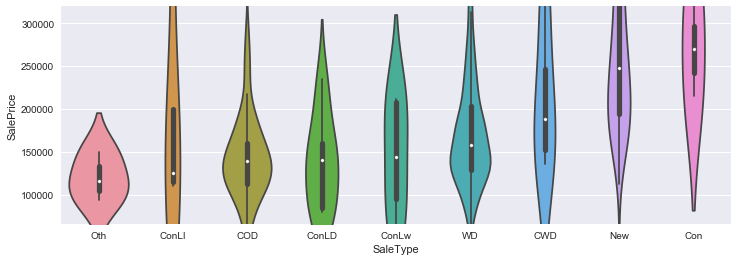

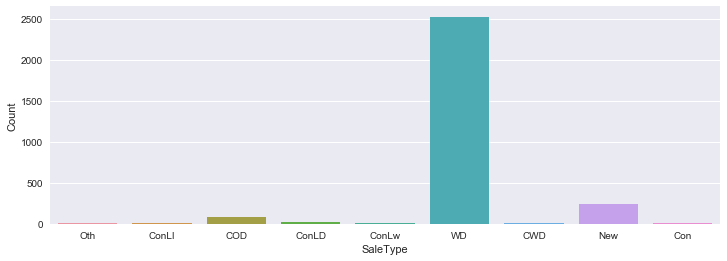

1  missing entries


In [49]:
data_profile(df, 'SaleType')

Same as SaleCondition; dropping it; although WD v.s. New does look kind of interesting.

HouseStyle:

    1Story	One story
    1.5Fin	One and one-half story: 2nd level finished
    1.5Unf	One and one-half story: 2nd level unfinished
    2Story	Two story
    2.5Fin	Two and one-half story: 2nd level finished
    2.5Unf	Two and one-half story: 2nd level unfinished
    SFoyer	Split Foyer
    SLvl	Split Level

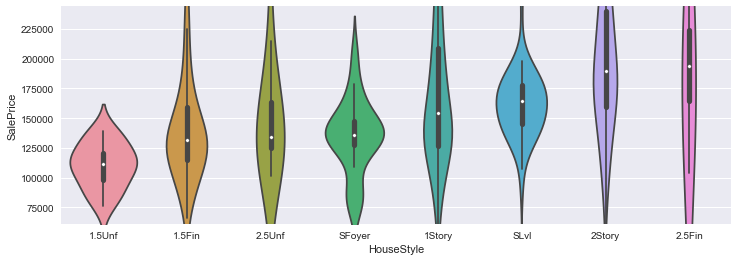

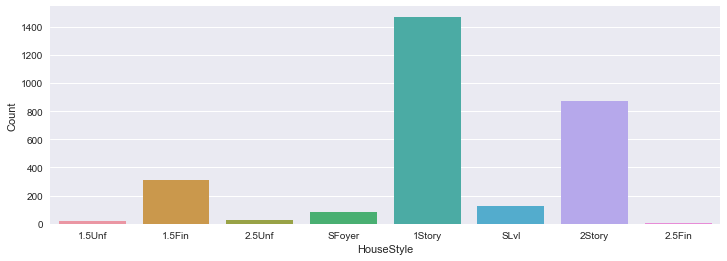

0  missing entries


In [50]:
data_profile(df, 'HouseStyle')

It seems worthwhile to keep this. Will merge 2.5Fin into 2Story and 2.5Unf into 1.5Fin.
We can consider something more elaborate, maybe a flag for "Unfinished 2nd story". Maybe later.

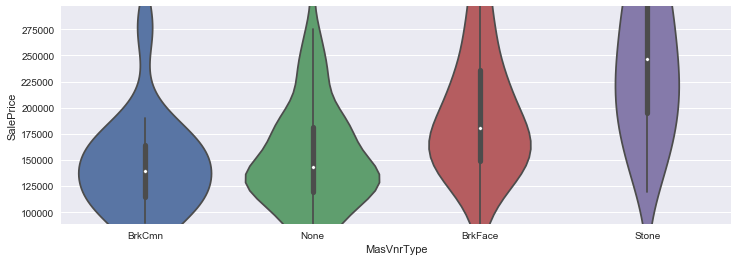

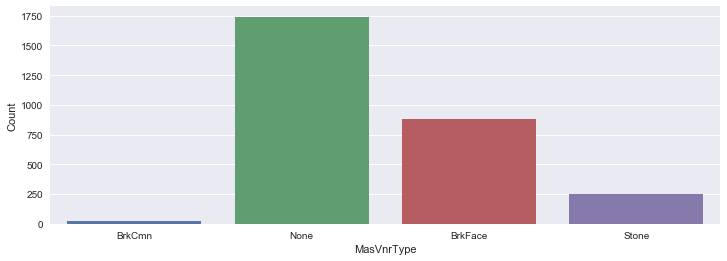

24  missing entries


In [51]:
data_profile(df, 'MasVnrType')

Some missing values. I think we can combine BrkCmn and None without much of an adverse effect. How about the missing entries? Do they have a MasVnrArea > 0?

In [52]:
df[df['MasVnrType'].isnull()][['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
Id,,
235,NaN,NaN
530,NaN,NaN
651,NaN,NaN
937,NaN,NaN
974,NaN,NaN
978,NaN,NaN
1244,NaN,NaN
1279,NaN,NaN
1692,NaN,NaN


Only one. We'll leave that MasVnrType to be imputed. The other will be filled with new combined value for BrkCmn&None.

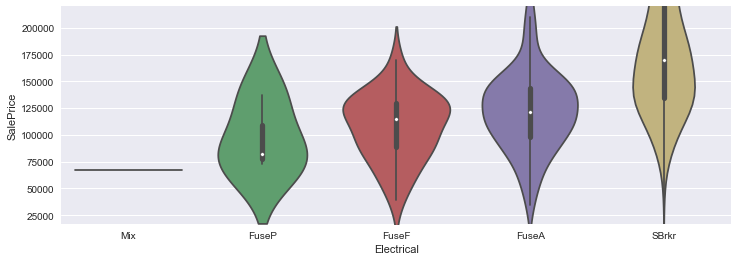

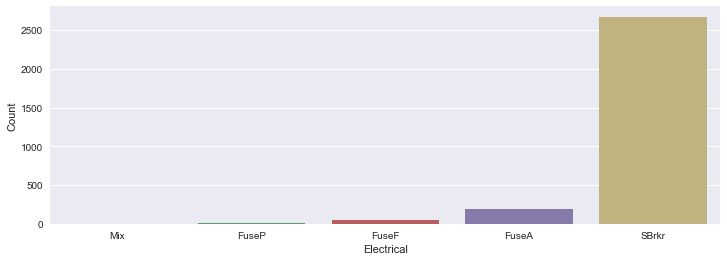

1  missing entries


In [53]:
data_profile(df, 'Electrical')

Very few entries in elements other than SBrkr. Will drop the column.

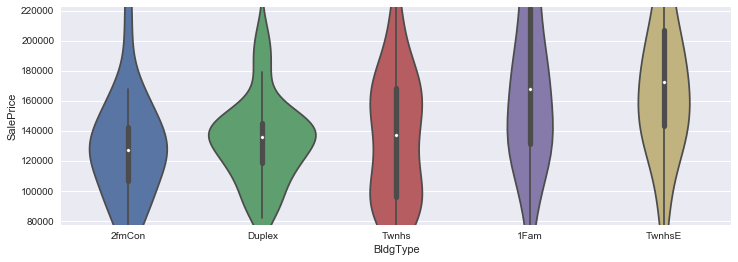

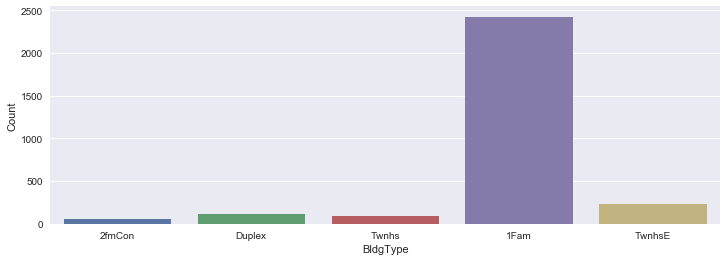

0  missing entries


In [54]:
data_profile(df, 'BldgType')

Keeping this for now.

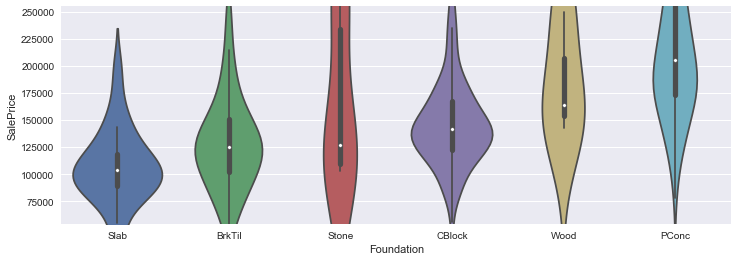

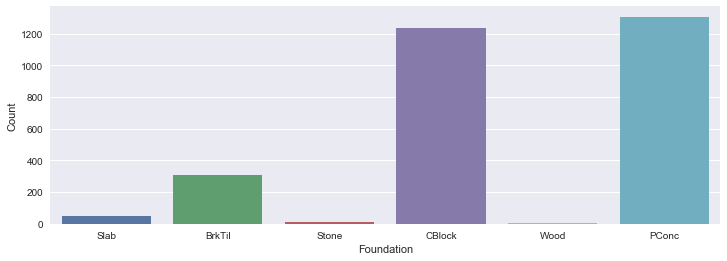

0  missing entries


In [55]:
data_profile(df, 'Foundation')

Having so few values for Stone and Wood might be problematic. I'll try to delete those and impute a value for similar houses. Not exactly true to reality, but makes for an easier to train model.

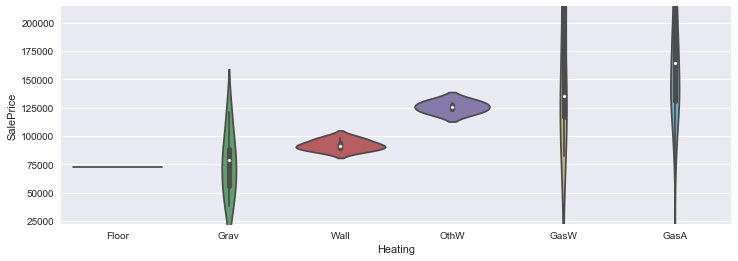

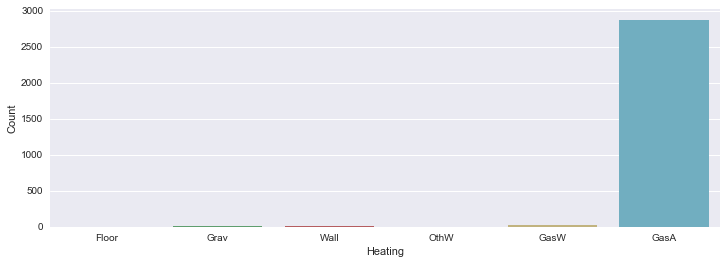

0  missing entries


In [56]:
data_profile(df, 'Heating')

Again, deleting "Floor" and "OthW" to let it get imputed to be one of the remaining categories seems to have improved my CV score a little bit. Deleting it entirely wasn't a good idea, as was a binary encoding using only GasA.

# Numeric columns

In [57]:
num_cols = ['WoodDeckSF', '1stFlrSF', '3SsnPorch', 'YearBuilt', 'LowQualFinSF', 'GrLivArea', 
            'BsmtUnfSF', 'MiscVal', 'YearRemodAdd', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 
            'BsmtFinSF1', 'LotArea', 'BsmtFinSF2', 'EnclosedPorch', 'GarageArea', 'TotalBsmtSF', 
            'ScreenPorch', 'OpenPorchSF', '2ndFlrSF']
num_cols = np.sort(num_cols)


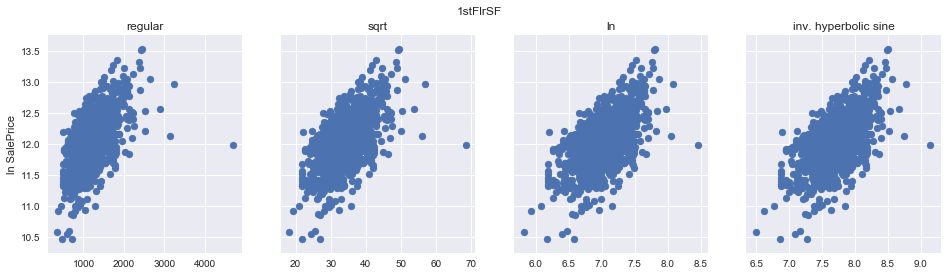

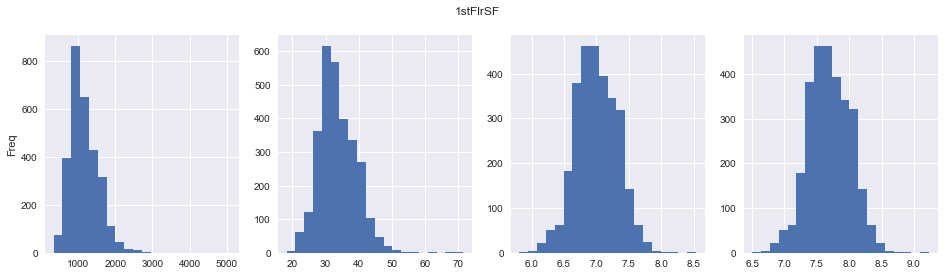

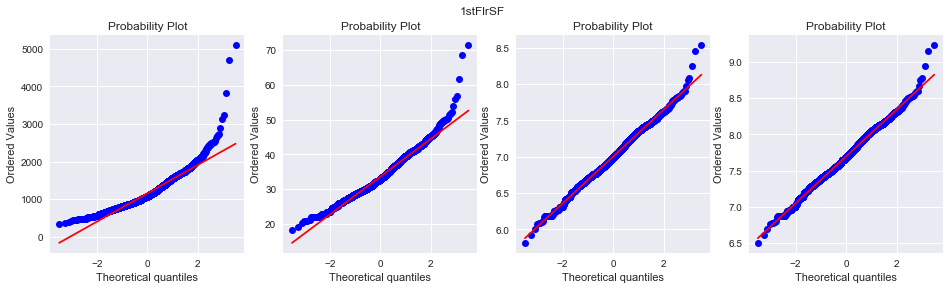

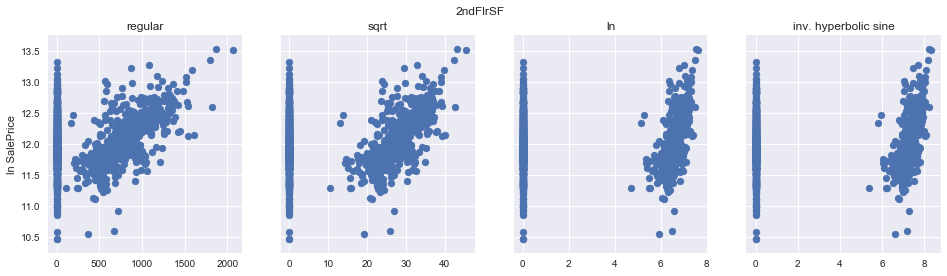

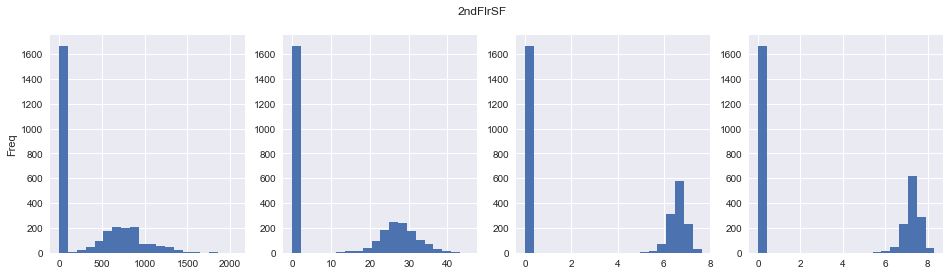

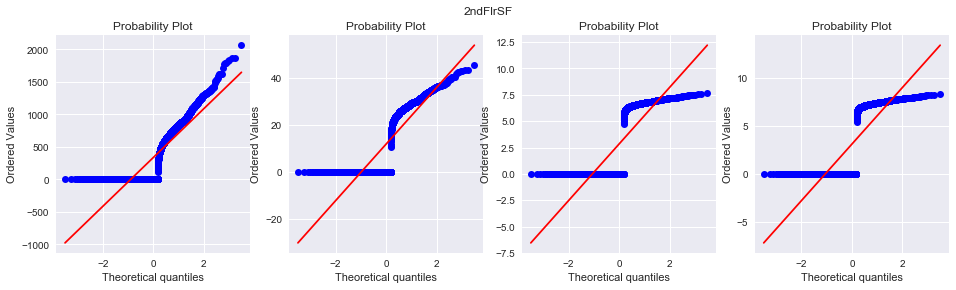

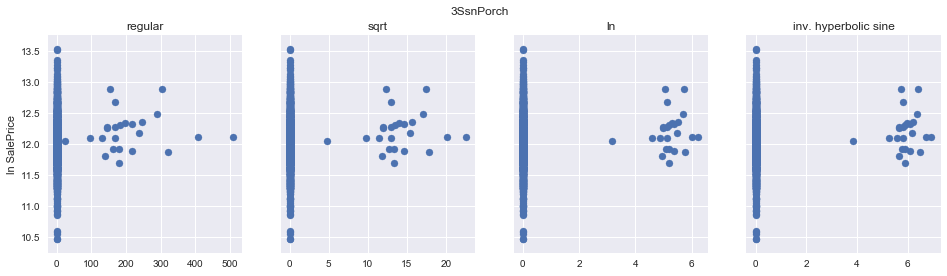

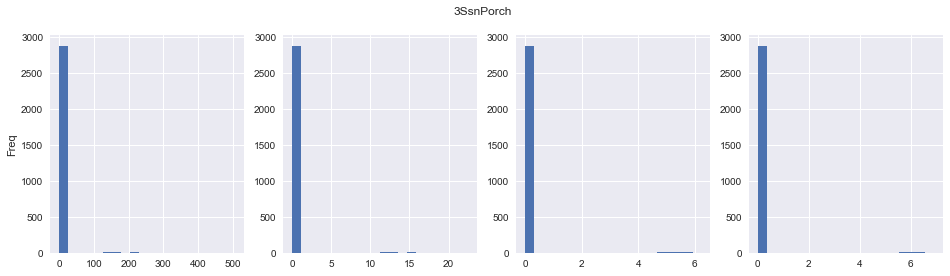

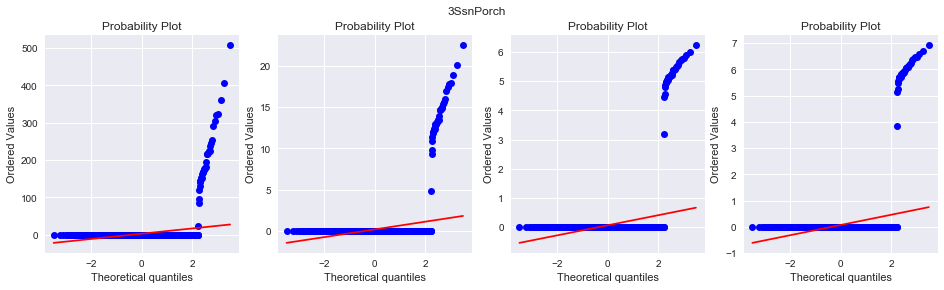

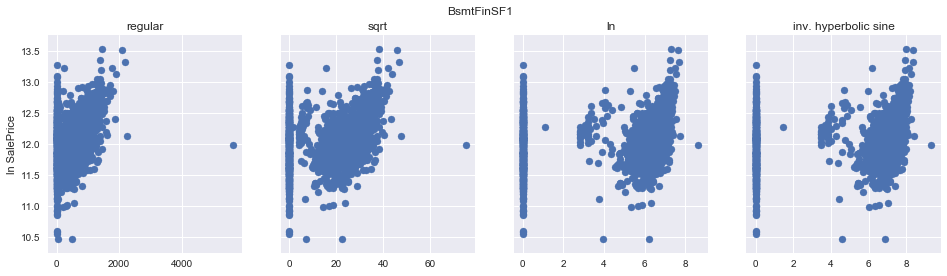

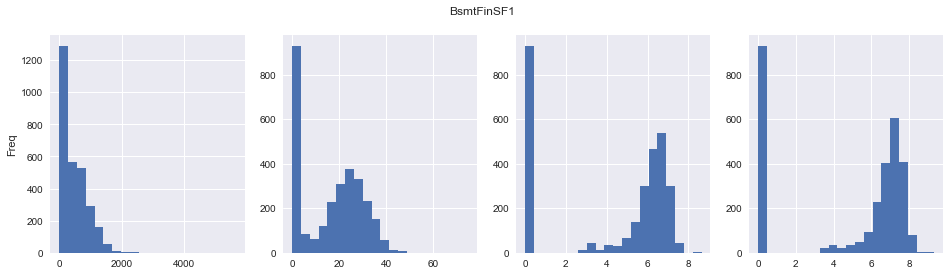

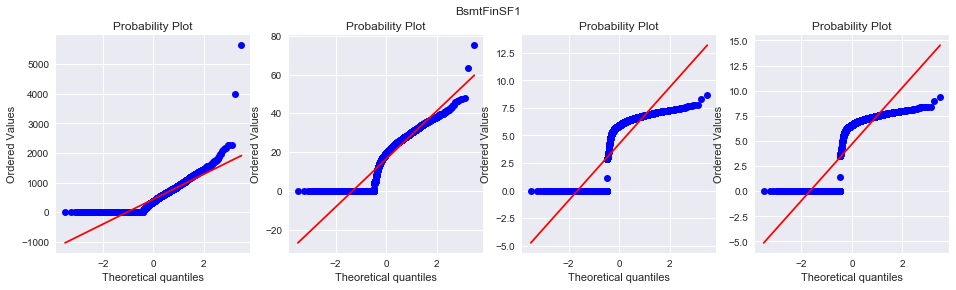

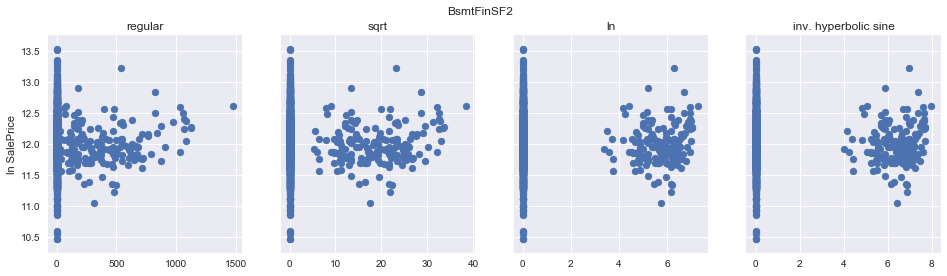

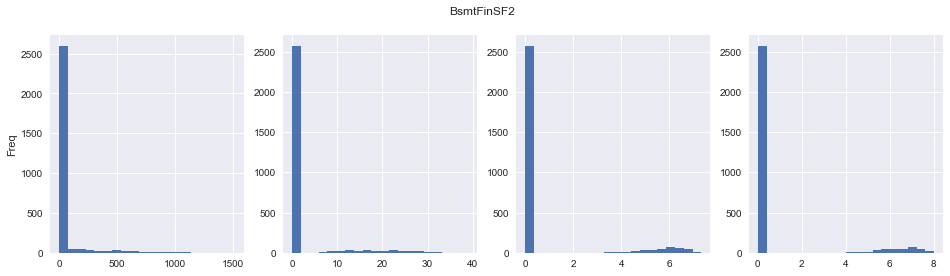

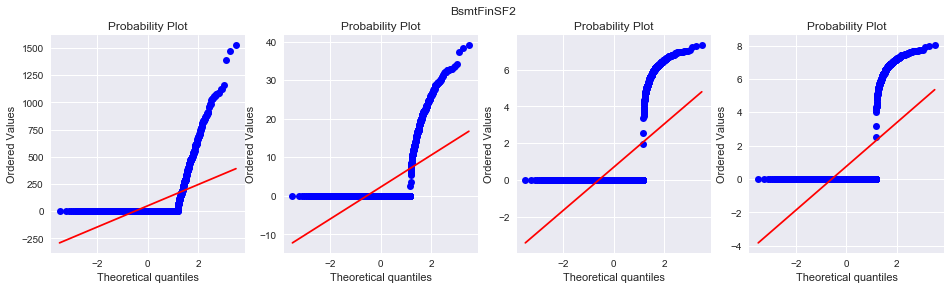

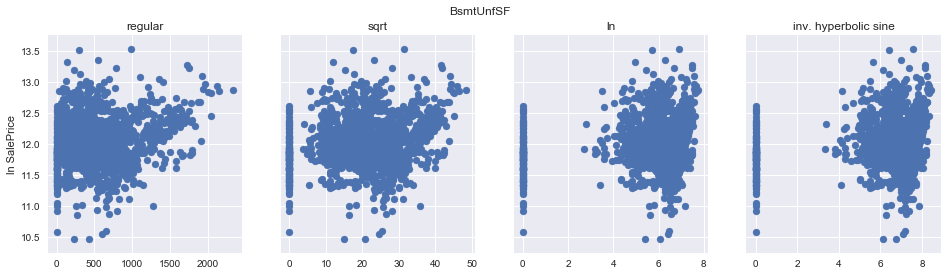

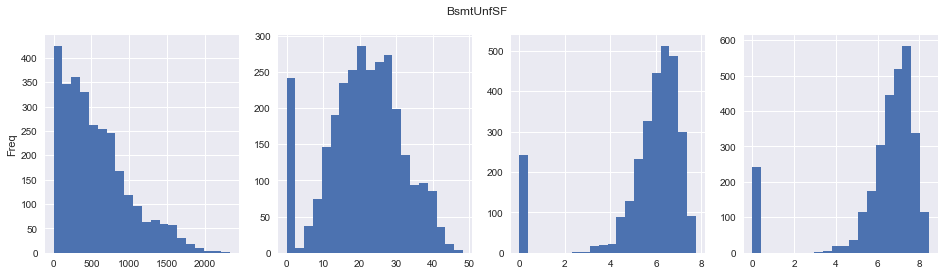

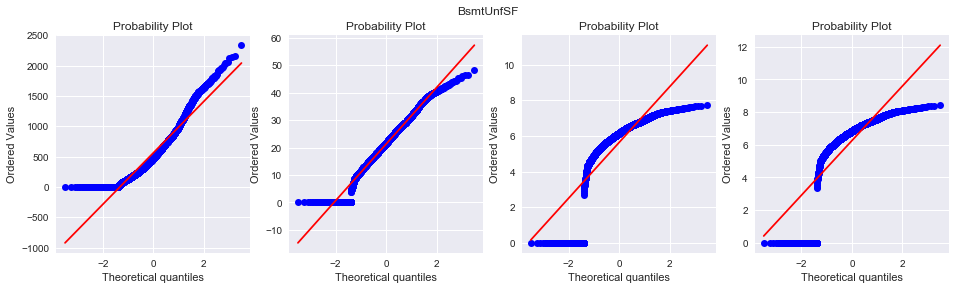

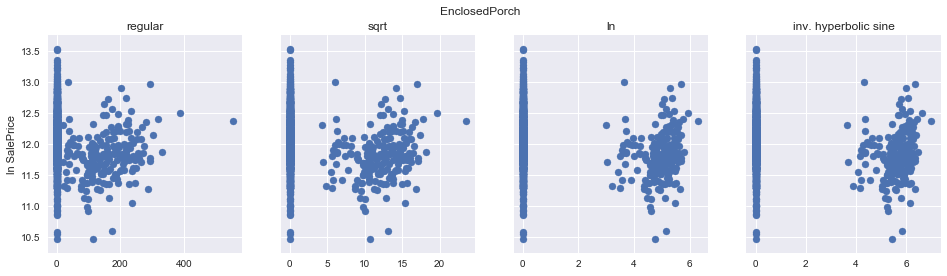

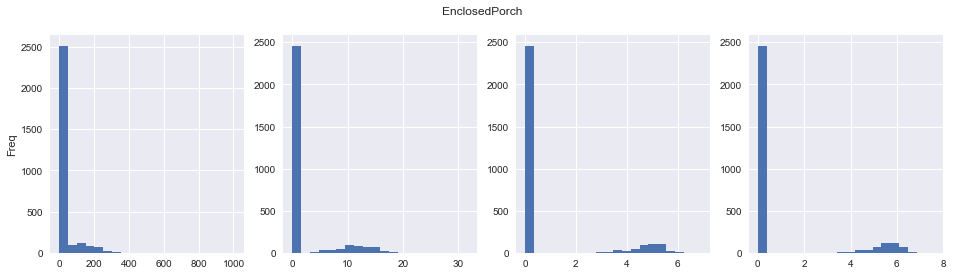

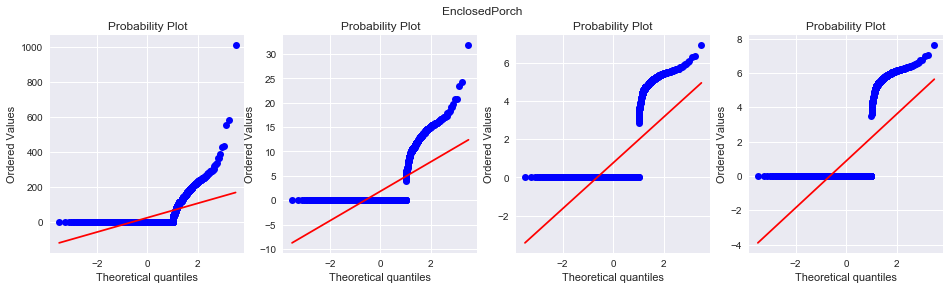

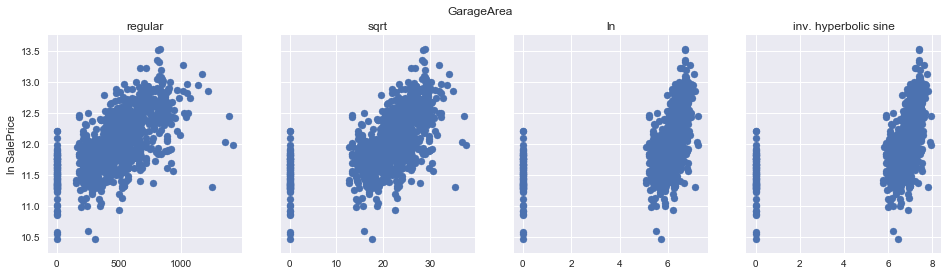

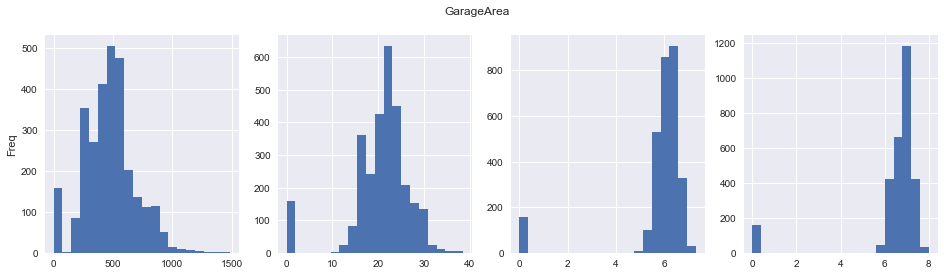

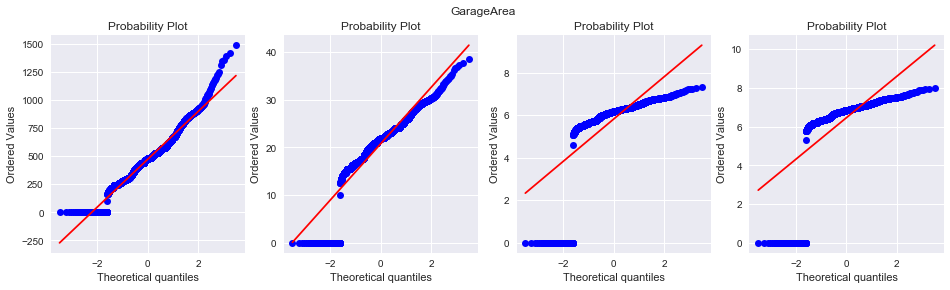

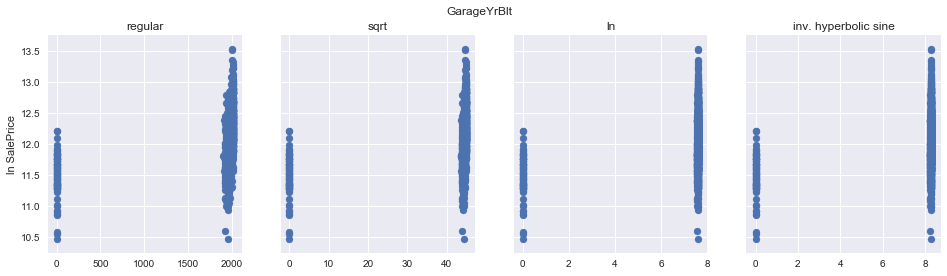

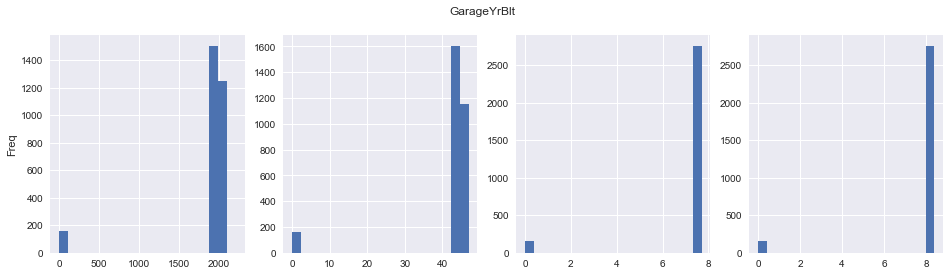

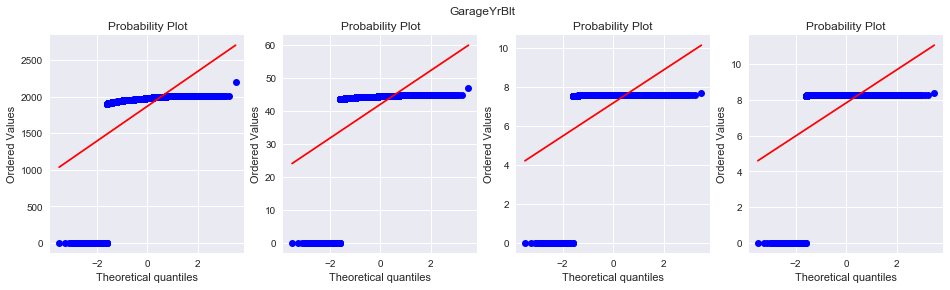

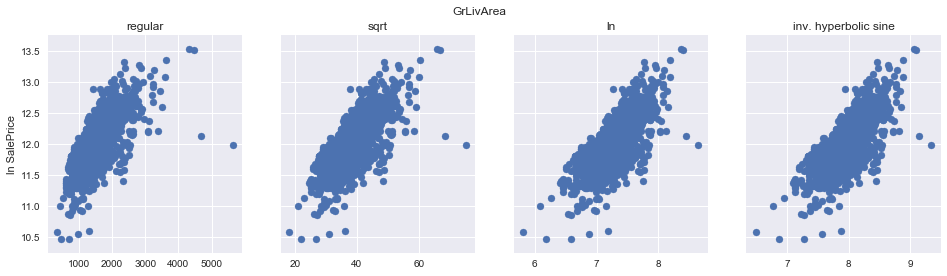

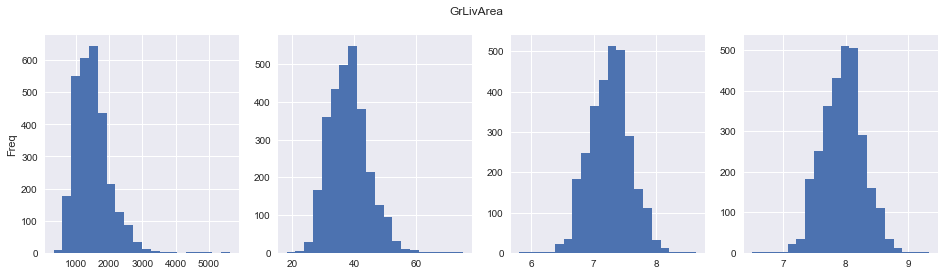

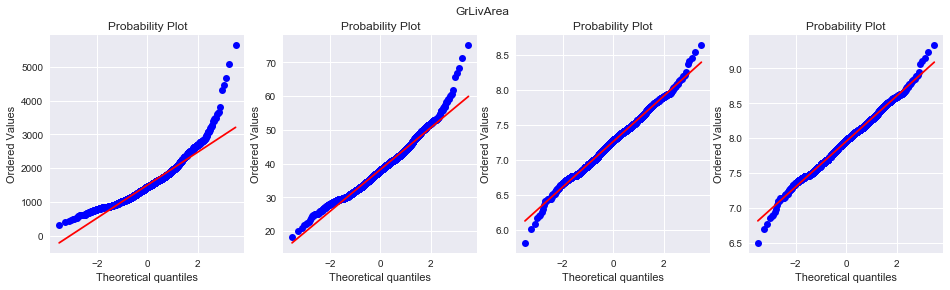

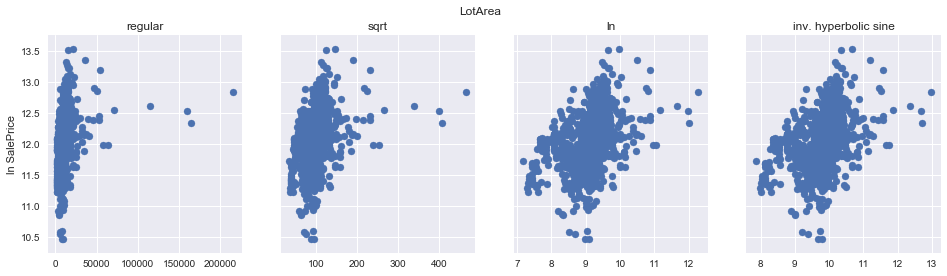

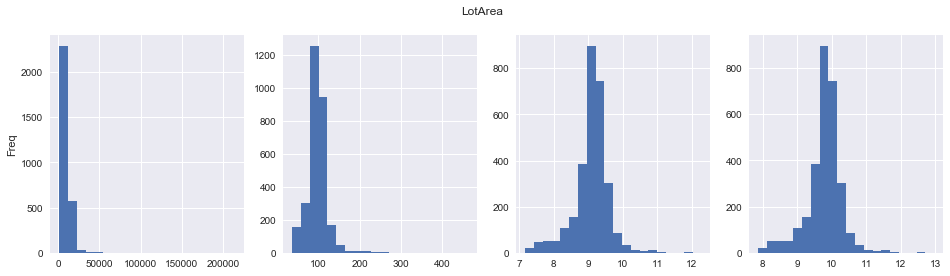

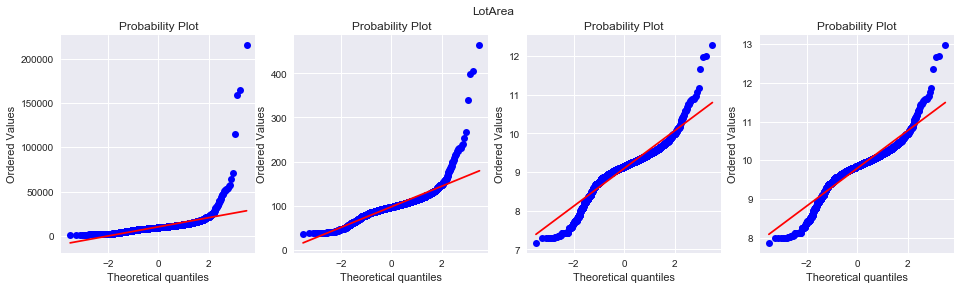

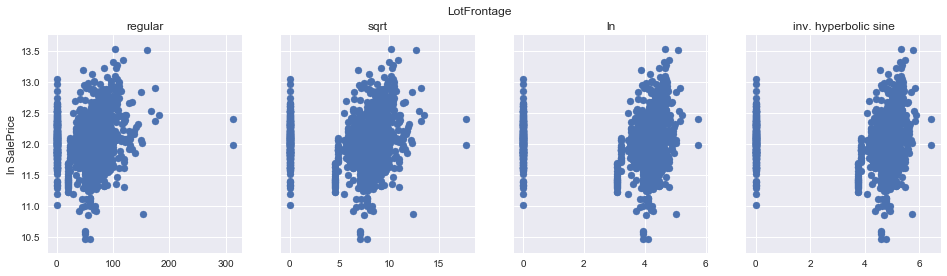

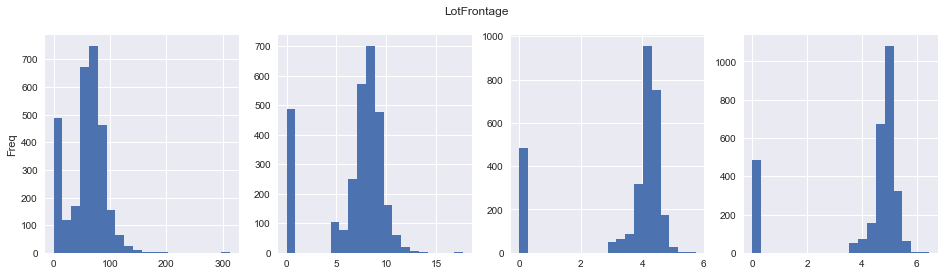

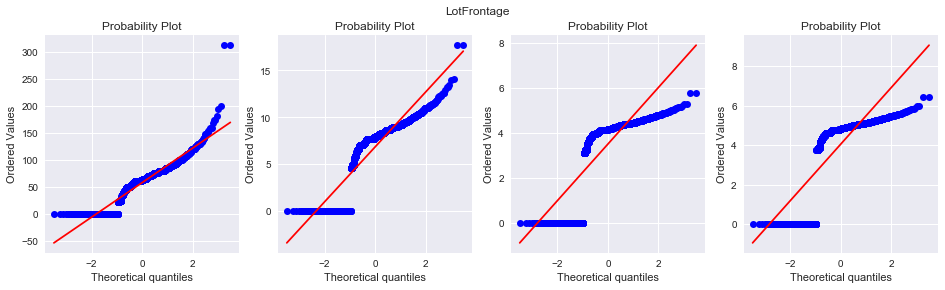

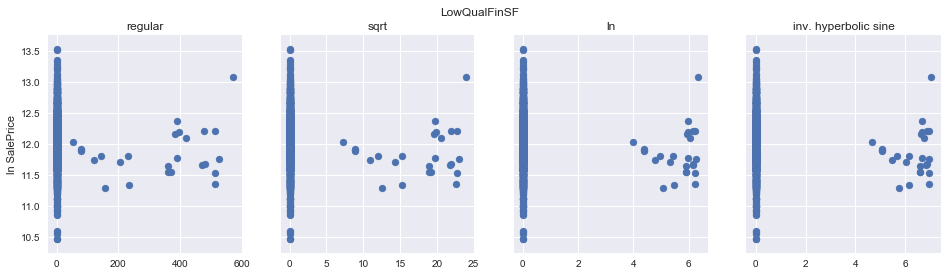

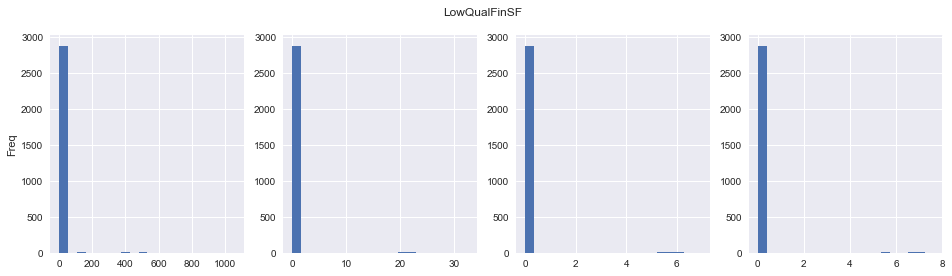

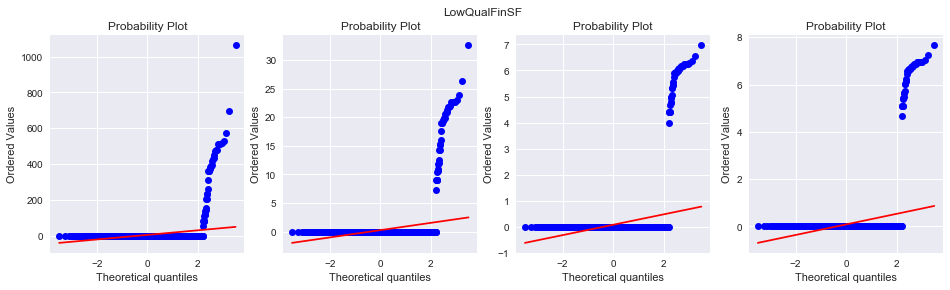

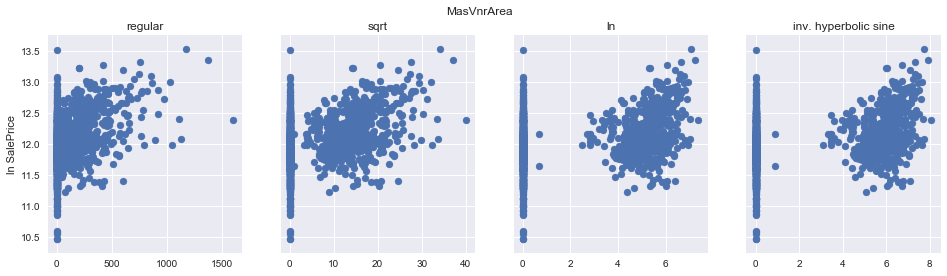

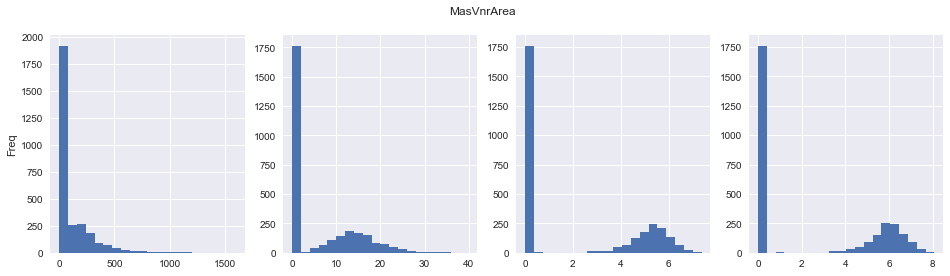

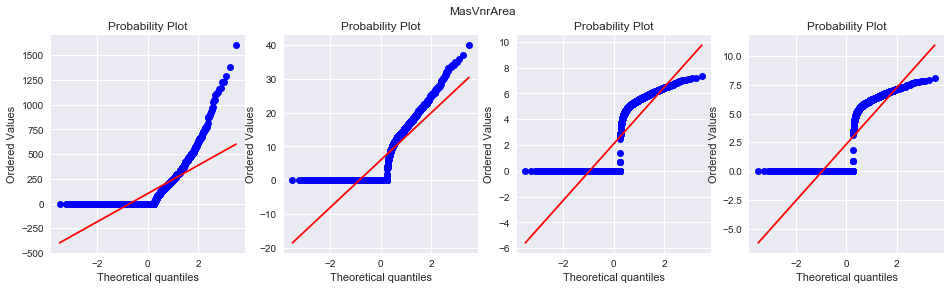

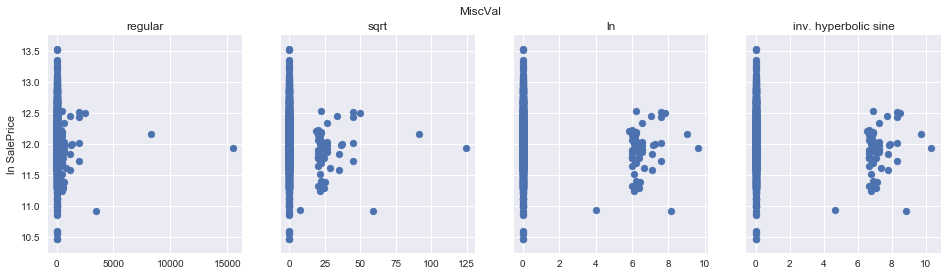

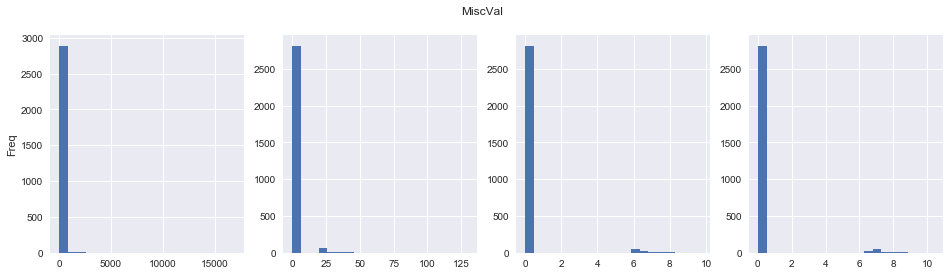

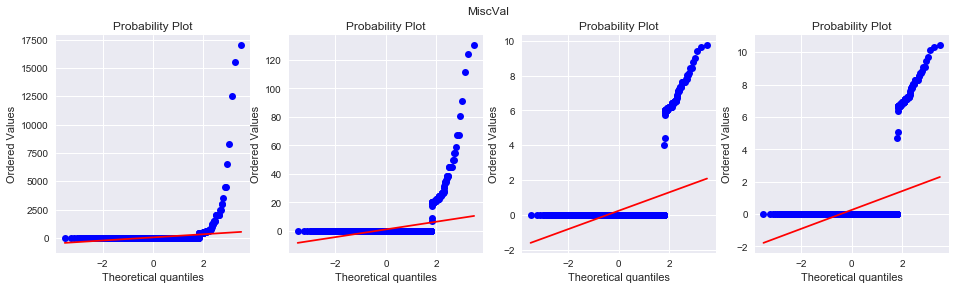

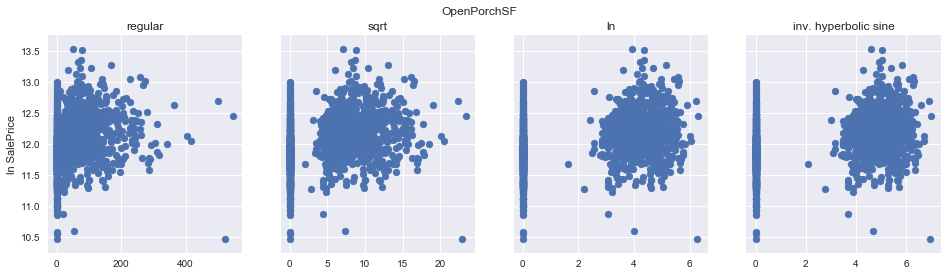

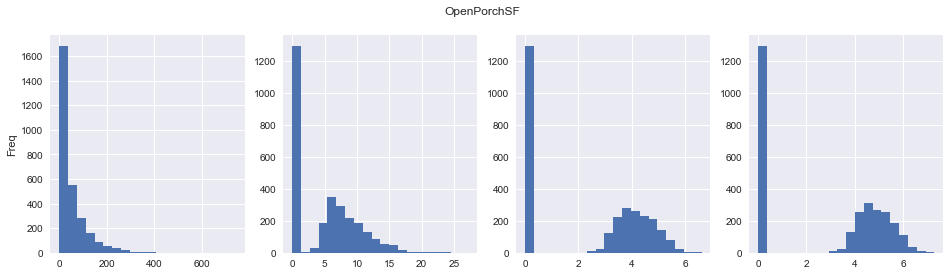

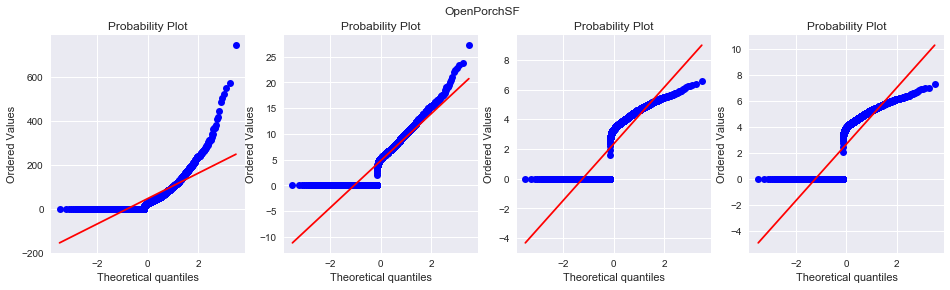

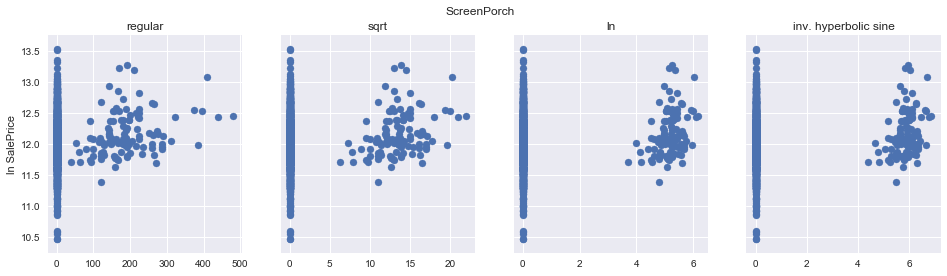

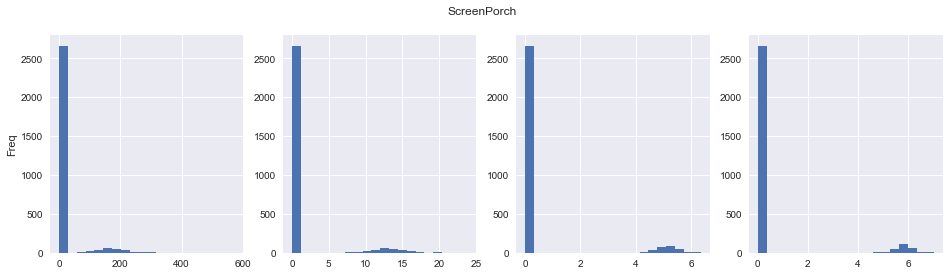

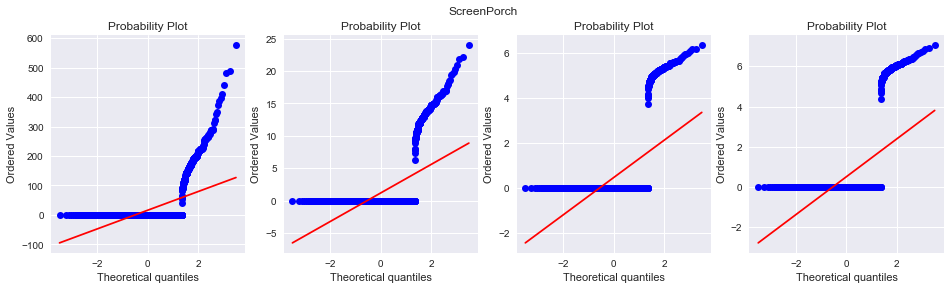

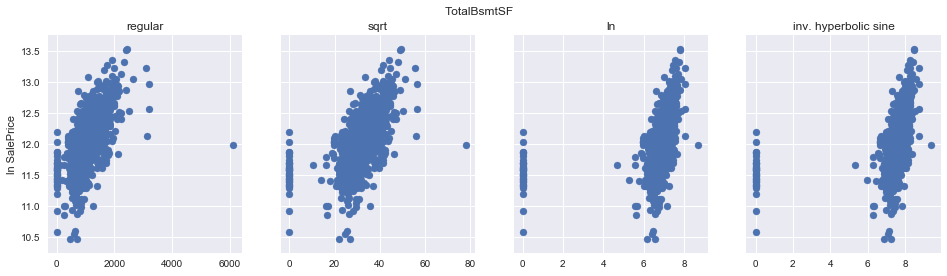

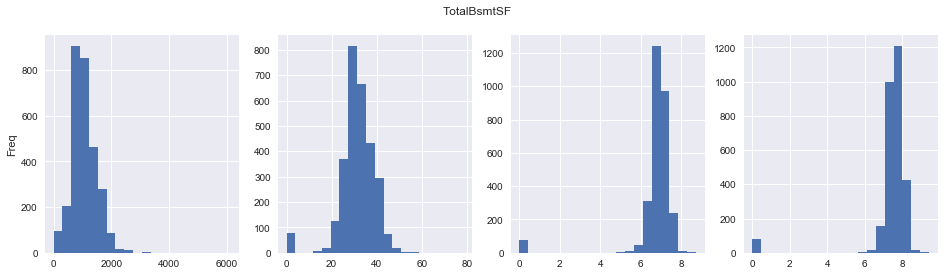

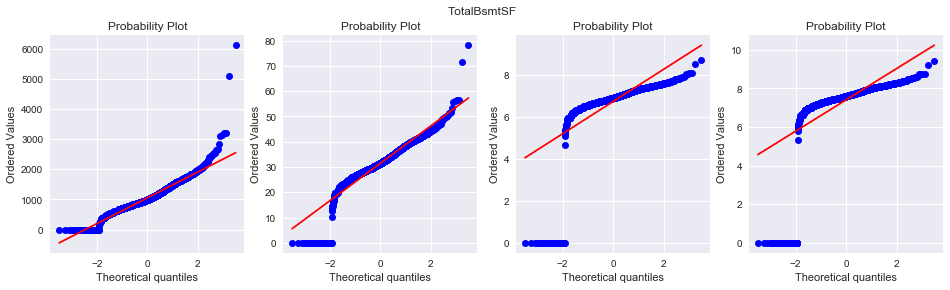

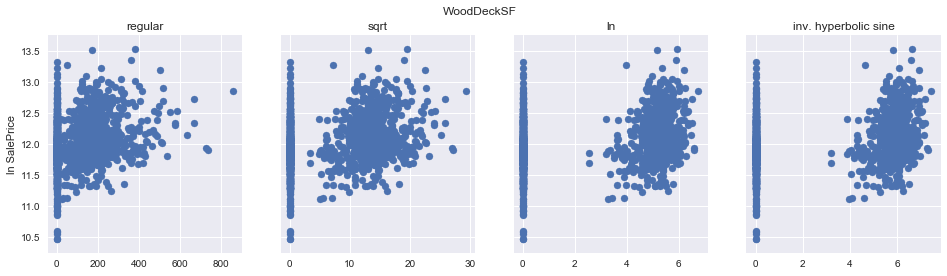

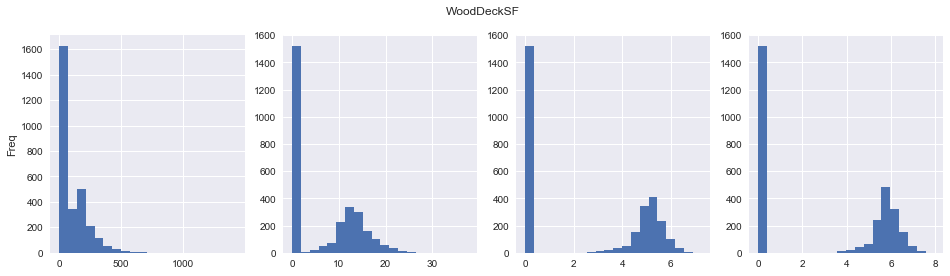

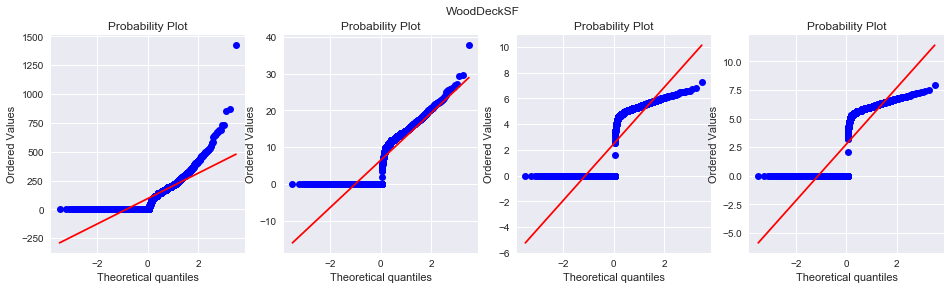

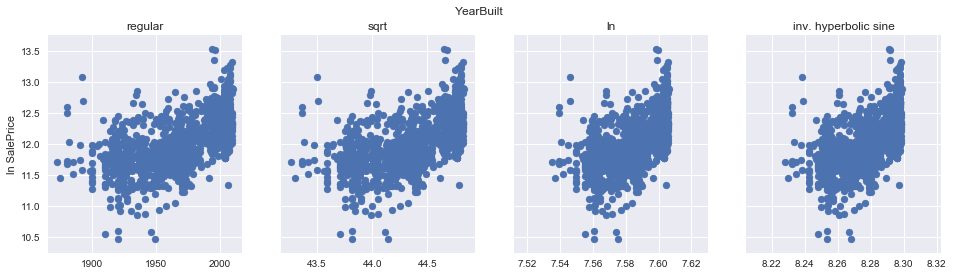

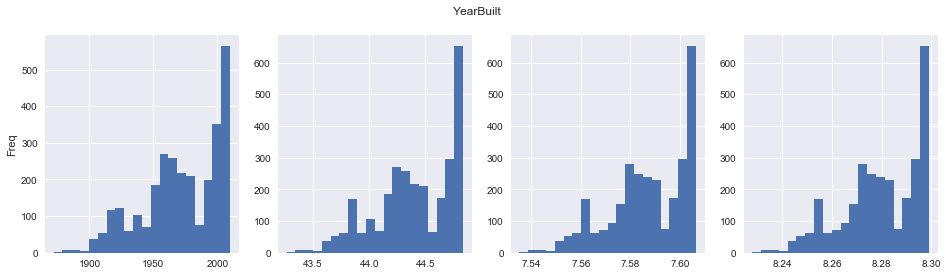

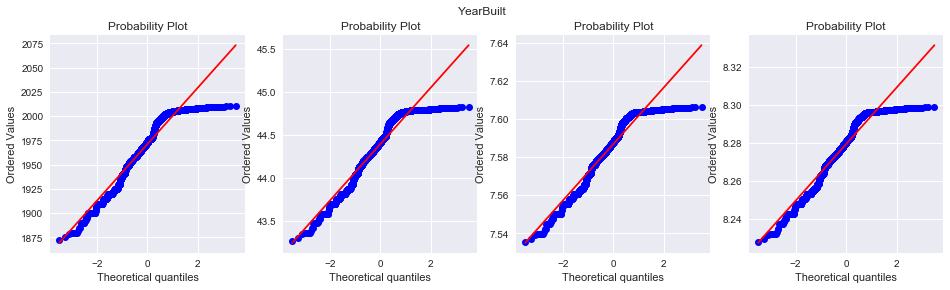

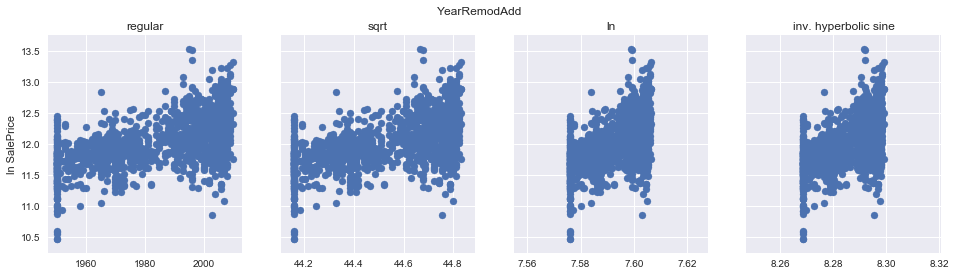

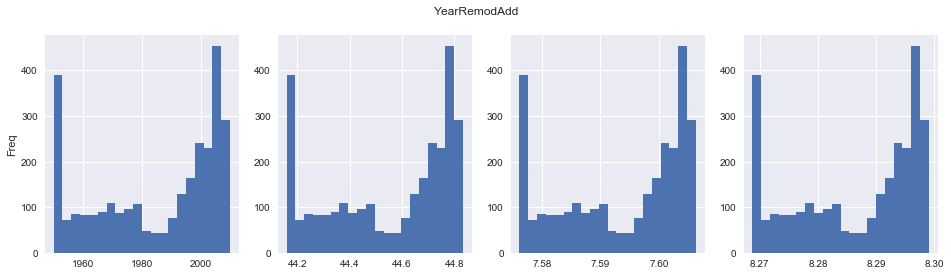

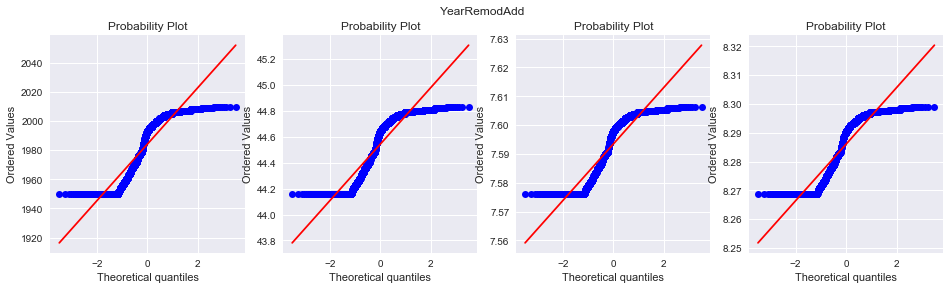

In [58]:
for col in num_cols:
    fig, (l, ml, mr, r) = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharey=True)
    ln_sp = np.log(df[COL_Y])
    
    cvals = df[col].fillna(0)
    ln_cvals = np.log(cvals + 1)
    sqrt_cvals = np.sqrt(cvals)
    ihs_cvals = np.log(cvals + np.sqrt((cvals ** 2 + 1)))
    
    l.scatter(cvals, ln_sp)
    l.set_title("regular")
    l.set_ylabel("ln SalePrice")
    ml.scatter(sqrt_cvals, ln_sp)
    ml.set_title("sqrt")
    mr.scatter(ln_cvals, ln_sp)
    mr.set_title("ln")
    r.scatter(ihs_cvals, ln_sp)
    r.set_title("inv. hyperbolic sine")
    fig.suptitle(col)
    
    fig, (l, ml, mr, r) = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
    l.hist(cvals, bins=20)
    l.set_ylabel("Freq")
    ml.hist(sqrt_cvals, bins=20)
    mr.hist(ln_cvals, bins=20)
    r.hist(ihs_cvals, bins=20)
    fig.suptitle(col)
    
    fig, (l, ml, mr, r) = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
    stats.probplot(cvals, dist="norm", plot=l)
    stats.probplot(sqrt_cvals, dist="norm", plot=ml)
    stats.probplot(ln_cvals, dist="norm", plot=mr)
    stats.probplot(ihs_cvals, dist="norm", plot=r)
    fig.suptitle(col)
    plt.show()

### Conclusions

#### log transform
- 1stFlrSF: log 
- LotFrontage: log 
- GrLivArea: log
- LotArea: log
- LotFrontage: log

#### Sqrt
- MasVnrArea
- OpenPorchSF
- TotalBsmtSF (maybe manually remove 1 outlier with value > 6000)
- WoodDeckSF

#### Delete
- 3SsnPorch: delete, very few values
- BsmtFinSF2: delete, very few values and not much of a correlation. Also delete BsmtFinType2.
- EnclosedPorch: delete, very few values
- LowQualFinSF: delete, very few values
- MiscVal: delete, very few values and mostly halfway in terms of SalePrice
- ScreenPorch: delete, very few values

#### Nothing/unsure
- GarageArea: nothing
- YearBuilt: nothing
- GarageYrBuilt: nothing... but the distribution looks a bit useless...
- 2ndFlrSF: TBD
- BsmtFinSF1: TBD
- BsmtUnfSF: TBD
- YearRemodAdd: nothing

### Ok, previous analysis showed a bunch of outliers. Let's isolate them.
- GarageYrBlt: One garage is built in 2200! Nice, from the future.
- GrLivArea: The relation is mostly linear but there's two that are huge with an average SalePrice.
- TotalBsmtSF: 1 value > 6000 with medium sale price.
- LotFrontage: 2 records with value ~ 300
- OpenPorchSF: 1 value > 300 but with very low saleprice. 

The approach I'm taking is: simply deleting them! Since we're using the KNN imputation algorithm, we'll fill in a new value from the most similar house out of the entire set.

In [59]:
v = df['GarageYrBlt']
v[v > 2100]

Id
2593    2207.0
Name: GarageYrBlt, dtype: float64

In [60]:
v = df[['GrLivArea', 'SalePrice']]
v[v['GrLivArea'] > 4000]

,GrLivArea,SalePrice
Id,,
524,4676,184750.0
692,4316,755000.0
1183,4476,745000.0
1299,5642,160000.0
2550,5095,NaN


In [61]:
df.loc[(524, 1299), 'GrLivArea']

Id
524     4676
1299    5642
Name: GrLivArea, dtype: int64

In [62]:
df[df['TotalBsmtSF'] > 6000][['TotalBsmtSF', 'SalePrice']]

,TotalBsmtSF,SalePrice
Id,,
1299,6110.0,160000.0


Hey, same Id as before! Maybe we're better off deleting the entire record...

In [63]:
df[df['LotFrontage'] > 300][['LotFrontage', 'SalePrice']]

,LotFrontage,SalePrice
Id,,
935,313.0,242000.0
1299,313.0,160000.0


In [64]:
df[df['OpenPorchSF'] > 300][['OpenPorchSF', 'SalePrice']].head(5)

,OpenPorchSF,SalePrice
Id,,
496,523,34900.0
524,406,184750.0
584,502,325000.0
646,312,143250.0
736,341,163000.0


# Quality metrics
Last one. There's a whole bunch of quality metrics that have values like "Go", "Po", "Ex" etc., for Good, Poor and Excellent. I haven't done an exhaustive analysis here (yet); for now I'm assuming that it makes sense to keep the ordering here and turn them from categorical string-based variables into a numeric value with values 0, 1, 2, 3, 4, etc. I'm not 100% sure if this makes sense, because that forces a linear relationship for the linear model with SalePrice. I expect it to work well for decision trees though.

I could be totally wrong about this - that's why I'm testing the performance of all transformations.

Example:

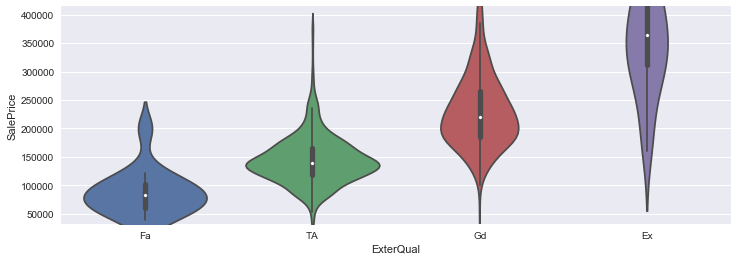

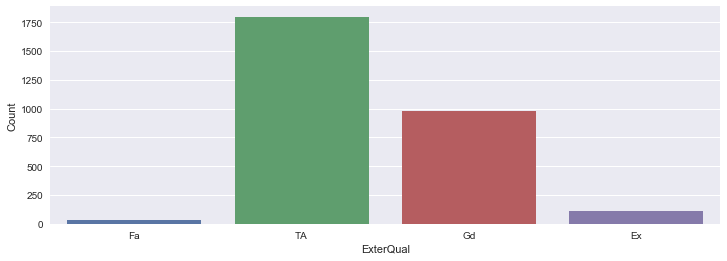

0  missing entries


In [65]:
data_profile(df, 'ExterQual')

This will get encoded as follows: Fa = 0, TA = 1, Gd = 2, Ex = 3. I'm using the median SalePrice as an ordering metric to avoid having to manually encode the ordering for each column. (There's a slight variation in the actual strings used across the columns). If a column contains missing values, it's also included in the ordering.